### <center>**Reading and Cleaning Annotation Data for Custom PyTorch Object Detection**</center> 

In [1]:
# Import necessary packages
%matplotlib inline
import json
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion(); # interactive mode

##### Helper functions for processing JSONs

In [2]:
# Function for reading JSON as dictionary
def read_json(filename: str) -> dict:
  
    try:
        with open(filename, "r") as f:
            data = json.loads(f.read())
    except:
        raise Exception(f"Reading {filename} file encountered an error")
  
    return data

# Function to append records to df
def create_dataframe(data: list) -> pd.DataFrame:

    # Create an empty dataframe to append records
    df = pd.DataFrame()
  
    # Looping through each record
    for d in data:
          
        # Normalize the column levels
        record = pd.json_normalize(d)

        df = pd.concat([df, record], axis=0)
          
    return df

# Main function to iterate over files in directory and add to df
def main():
    # Assign directory and empty df for appending annotations
    directory = "C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/" # annotation directory
    annos_df = pd.DataFrame()
    
    # Iterate over files in directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            print(f)
            
        # Read the JSON file as python dictionary 
        data = read_json(filename = f)
    
        # Create the dataframe for the array items in annotations key 
        df = create_dataframe(data = data['annotations'])
        df.insert(loc = 0, column = 'img_name', value = f'{f[-30:-5]}.JPG')
    
        df.rename(columns = {
            "img_name": "img_name",
            "name": "label",
            "bounding_box.h": "bbox_height",
            "bounding_box.w": "bbox_width",
            "bounding_box.x": "bbox_x_topLeft",
            "bounding_box.y": "bbox_y_topLeft",
            "polygon.paths": "polygon_path"
        }, inplace = True)
        
        # Append the df dataframe to the annos_df dataframe
        annos_df = pd.concat([annos_df, df], ignore_index=True)

    # Convert x, y, h, w to xmin, ymin, xmax, ymax
    annos_df.insert(loc = 2, column = 'xmin', 
                    value = annos_df['bbox_x_topLeft'])
    annos_df.insert(loc = 3, column = 'ymin', 
                    value = annos_df['bbox_y_topLeft'])
    annos_df.insert(loc = 4, column = 'xmax', 
                    value = annos_df['bbox_x_topLeft'] + annos_df['bbox_width'])
    annos_df.insert(loc = 5, column = 'ymax', 
                    value = annos_df['bbox_y_topLeft'] + annos_df['bbox_height']) 
  
    # Drop unneccessary columns 
    annos_df = annos_df.drop(columns = ['bbox_height', 'bbox_width', 'bbox_x_topLeft', 
                                        'bbox_y_topLeft', 'id', 'slot_names', 'polygon_path'])
        
    return annos_df

##### Load annotation data into dataframe

In [3]:
# Execute main loading function
if __name__ == '__main__':
    df = main()

C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/DJI_20211215103949_0003_Z.json
C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/DJI_20211215103957_0004_Z.json
C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/DJI_20211215105707_0002_Z.json
C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/DJI_20211215105716_0003_Z.json
C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/DJI_20211215105736_0004_Z.json
C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/DJI_20211215105752_0005_Z.json
C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/DJI_20211215105813_0006_Z.json
C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/DJI_20211215105821_0007_Z.json
C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/DJI_20211215105829_0008_Z.json
C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotations/DJI_20211215105920_0009_Z.json
C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Annotatio

##### Filter annotation dataframe

In [4]:
# If label value count is less than 200, drop the row
df = df.groupby('label').filter(lambda x : len(x) > 200)

# If label value is 'Hen', drop the row
df = df[df['label'] != 'Hen']

##### Filter images since most annotation class were filtered out

In [5]:
# Store unique img_names in filtered df as array
img_names = df['img_name'].unique().tolist()

# Create a new directory called 'filtered_images'
new_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)

# Copy images in img_names to new directory
for img in img_names:
    shutil.copy2(f'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/Images/{img}', new_dir)

### <center>**Transform and Augment Image and Annotation Data for Custom PyTorch Object Detection**</center> 

In [6]:
# import necessary packages
import numpy as np
from PIL import Image
from io import BytesIO
from collections import defaultdict
import torch
from torch.utils.data import Dataset
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.io import read_image
from torchvision import datapoints as dp
import torchvision.transforms.v2 as T
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
import utils

##### Pre-process annotation data

In [7]:
# use ordinal encoder to convert df['label'] to numeric values. 0 is reserved for background class.
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
df.insert(loc = 6, column = 'target', value = (oe.fit_transform(df[['label']])) + 1)

# Create a dictionary using df['label'] as the keys and df['label_code'] as the values
label_dict = dict(zip(df['target'], df['label']))

# Drop label column from df
df = df.drop(['label'], axis = 1)

# Change target column name to label
df.rename(columns = {'target': 'label'}, inplace = True)

# Save df as csv in directory
df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_annotations.csv', index = False)

##### PyTorch dataset for custom image and annotation data

In [8]:
# Custom dataset loader (PyTorch) for loading images and annotation data
class MAVdroneDataset(Dataset):
    """Dataset Loader for Waterfowl Drone Imagery"""

    def __init__(self, csv_file, root_dir, transforms):
        """
        Arguments:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory containing all images.
            transforms (string): train = True for training transforms
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir

        self.transforms = transforms
        self.unique_image_names = self.df['img_name'].unique()


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = self.unique_image_names[idx]

        # isolate first row prevents multiple instances of the same image
        row = self.df[self.df['img_name'] == image_name].iloc[0]

        image_path = os.path.join(self.root_dir, row['img_name'])
        image = None

        # ignore corrupted image data during loading else error
        while True:
            with open(image_path, 'rb') as f:
                buff = BytesIO()
                buff.write(f.read())
                buff.seek(0)
                temp_image = np.array(Image.open(buff), dtype = np.uint8)
                # convert np.array to Tensor[image_channels, image_height, image_width]
                image = torch.from_numpy(temp_image).permute(2, 0, 1)

            if image is not None:
                break

        boxes = self.df[self.df['img_name'] == image_name][['xmin', 'ymin', 'xmax', 'ymax']].values 
        labels = self.df[self.df['img_name'] == image_name]['label'].values

        labels = torch.as_tensor(labels, dtype = torch.int64) # (n_objects)

        boxes = torch.as_tensor(boxes, dtype = torch.float32)

        # if xmin > xmax, flip them so width is always positive
        if torch.any(boxes[:, 0] > boxes[:, 2]):
            boxes[:, [0, 2]] = boxes[:, [2, 0]]
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
            
        target = {}
        target['boxes'] = dp.BoundingBox(boxes, format = "XYXY", spatial_size = (image.shape[1], image.shape[2]))
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        image = dp.Image(image)

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target


    def __len__(self):
        return len(self.unique_image_names)

##### Data transformation function

In [9]:
# ImageNet mean and std since using pretrained VGG16 backbone
mean = [0.485, 0.456, 0.406] # 3 bands
std = [0.229, 0.224, 0.225]

# Same transforms as original SSD paper
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomZoomOut(fill = defaultdict(lambda: 0, {dp.Image: (255, 20, 147)}),
                                          p = 0.3,
                                          side_range = (1.0, 2.0)))
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.Resize((300, 300), antialias = True)) # no maintain aspect ratio
        transforms.append(T.RandomHorizontalFlip(0.5))
    else:
        transforms.append(T.Resize((300, 300), antialias = True)) # no maintain aspect ratio
    transforms.append(T.ToImageTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    transforms.append(T.SanitizeBoundingBox())
    transforms.append(T.Normalize(mean, std)) # ImageNet mean and std values for normalization
    return T.Compose(transforms)

##### Helper functions for plotting image and annotations

In [10]:
# classes are values in label_dict
classes = list(label_dict.values())

# reverse label dictionary for mapping predictions to classes
rev_label_dict = {v: k for k, v in label_dict.items()}

# distinct colors 
bbox_colors = ['#f032e6', '#ffffff', '#ffe119', '#3cb44b', '#42d4f4',
                    '#f58231', '#e6194B', '#dcbeff', '#469990', '#4363d8']

# label color map for plotting color-coded boxes by class
label_color_map = {k: bbox_colors[i] for i, k in enumerate(label_dict.keys())}

# function for reshaping boxes 
def get_box(boxes):
    boxes = np.array(boxes)
    boxes = boxes.astype('float').reshape(-1, 4)
    if boxes.shape[0] == 1 : return boxes
    return np.squeeze(boxes)


# function for plotting image
def img_show(image, ax = None, figsize = (6, 9)):
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    ax.xaxis.tick_top()
    ax.imshow(image)
    return ax
 

def plot_bbox(ax, boxes, labels):
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.5))
    # add label text to bounding box using label_dict if label exists else labels
    ax.text(boxes[:, 2], boxes[:, 3], 
            (label_dict[labels.item()] if labels.item() in label_dict else labels.item()),
            fontsize = 8,
            bbox = dict(facecolor = 'white', alpha = 0.8, pad = 0, edgecolor = 'none'),
            color = 'black')


# function for plotting all boxes and labels on the image using get_polygon, img_show, and plot_mask functions
def plot_detections(image, boxes, labels, ax = None):
    ax = img_show(image.permute(1, 2, 0), ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i])
        plot_bbox(ax, box, labels[i])

##### Plot sample batch to confirm data loads and transforms correctly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


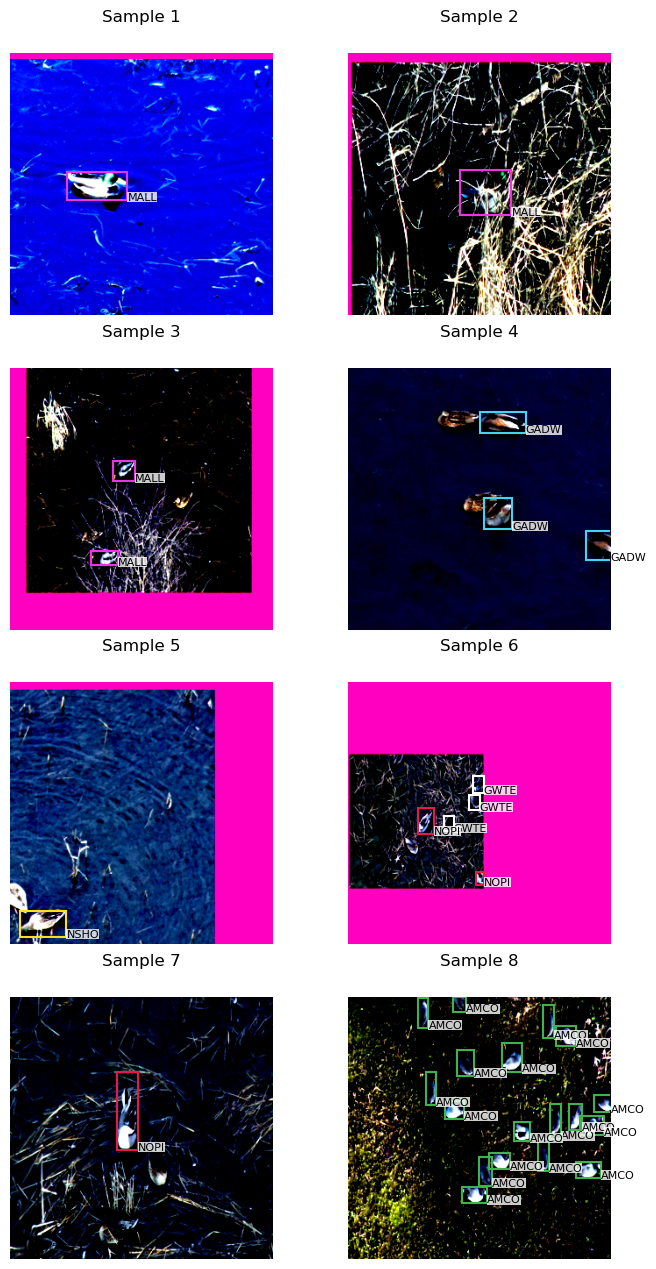

In [11]:
# Load sample batch of data to custom PyTorch Dataset and Transform
sample_dataset = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_annotations.csv', 
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images', 
                                transforms = get_transform(train = True))

# store image indices in random order list
indices = torch.randperm(len(sample_dataset)).tolist()

sample_data_loader = torch.utils.data.DataLoader(sample_dataset, batch_size = 8, shuffle = True, 
                                             collate_fn = utils.collate_fn, num_workers = 0)

# store images and annotation targets from sample batch
images, targets = next(iter(sample_data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

# Plot the all samples from batch in a grid of subplots. 
plt.figure(figsize = (8, 32))
for i in range(8):
    ax = plt.subplot(8, 2, 1 + i)
    plot_detections(images[i], targets[i]['boxes'], targets[i]['labels'], ax = ax)
    plt.axis('off')
    plt.title(f"Sample {i + 1}")

plt.show()

### <center>**Tune Model Hyperparameters using Ray Tune**</center> 

In [12]:
import tempfile
from datetime import datetime
from engine import train_one_epoch, evaluate # comment out if using gradient accumulation
# from engine_gradientAccumulation import train_one_epoch, evaluate # uncomment if using gradient accumulation
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.bayesopt import BayesOptSearch
import torch.nn as nn

##### Helper functions for hyperparameter tuning

In [13]:
# Wrap data loaders in function and pass global data directories. 
def load_data(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_annotations.csv', 
              root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/'):
    
    # use MAVdroneDataset and defined transformations
    dataset = MAVdroneDataset(csv_file = csv_file,
                                root_dir = root_dir, 
                                transforms = get_transform(train = True))
    
    dataset_val = MAVdroneDataset(csv_file = csv_file,
                                root_dir = root_dir, 
                                transforms = get_transform(train = False))
    
    return dataset, dataset_val

def train_MAVdroneDataset(config, indices):
    model = ssd300_vgg16(weights = SSD300_VGG16_Weights.DEFAULT, 
                        weights_backbone = 'VGG16_Weights.IMAGENET1K_FEATURES')
    
    device = "cpu" 
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model) # train on multiple GPUs if available
    model.to(device)

    # construct an optimizer 
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr = config["lr"],
                                momentum = config["momentum"], 
                                weight_decay = config["weight_decay"])
    
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size = config["step_size"], # period of lr decay
                                                   gamma = config["gamma"]) # multiplicative factor of lr decay

    # Load existing checkpoint if exist.
    if train.get_checkpoint():
        loaded_checkpoint = train.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            )
            model.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)
    else:
        start_epoch = 0

    dataset, dataset_val = load_data()

    # subset using a 80/15/5 split for train, validation, and test datasets
    dataset_train = torch.utils.data.Subset(dataset, indices[:-int(len(dataset)*0.2)]) # first 80% of dataset

    dataset_val = torch.utils.data.Subset(dataset_val, indices[-int(len(dataset)*0.2):-int(len(dataset)*0.05)]) # next 15% of dataset

    # # Uncomment if using gradient accumulation
    # training_steps = [
    #     {"step": 0, "batch_size": 16, "epochs": 15, "print_freq": 10, 'accumulation_steps': 1}, 
    #     {"step": 1, "batch_size": 64, "epochs": 15, "print_freq": 5, 'accumulation_steps': 1},
    #     {"step": 2, "batch_size": 64, "epochs": 10, "print_freq": 5, 'accumulation_steps': 4}, # gpu memory maxes out at batch size 64
    #     {"step": 3, "batch_size": 64, "epochs": 5, "print_freq": 5, 'accumulation_steps': 16}, # batch size 1024 via gradient accumulation
    # ]

    # comment out if using gradient accumulation
    training_steps = [
            {"step": 0, "batch_size": 16, "epochs": 10, "print_freq": 10},
            {"step": 1, "batch_size": 64, "epochs": 15, "print_freq": 5}, 
            {"step": 2, "batch_size": 256, "epochs": 10, "print_freq": 2},  
            {"step": 3, "batch_size": 1024, "epochs": 10, "print_freq": 1}
        ]

    # loop through training_steps during training to increase batch size and decrease learning rate
    for step in training_steps:
        batch_size = int(step['batch_size'])
        num_epochs = int(step['epochs'])
        print_freq = int(step['print_freq'])
        # accumulation_steps = int(step['accumulation_steps']) # uncomment if using gradient accumulation

        # define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size, shuffle = True, 
                                                collate_fn = utils.collate_fn, num_workers = 0,
                                                pin_memory = True)
        
        data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 1, shuffle = False,
                                                    collate_fn = utils.collate_fn, num_workers = 0,
                                                    pin_memory = True)

        print(f'Beginning training step {step["step"]}... batch size: {batch_size}')

        for epoch in range(start_epoch, num_epochs + start_epoch):
            print()
            print(f'Epoch {epoch} beginning training...')
            print()

            # # uncomment if using gradient accumulation
            # train_metric_logger, val_metric_logger = train_one_epoch(model, optimizer, data_loader, accumulation_steps, device, epoch, print_freq, data_loader_val)

            # comment out if using gradient accumulation
            train_metric_logger, val_metric_logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, data_loader_val)

            # update the learning rate
            lr_scheduler.step()

            print()
            print(f'Epoch {epoch} preparing to evaluate the validation dataset...')
            print()
            
            # evaluate on the val dataset
            train_coco_evaluator, val_coco_evaluator = evaluate(model, data_loader, device, data_loader_val)

            # Here we save a checkpoint. It is automatically registered with Ray Tune
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
                torch.save(
                    (model.state_dict(), optimizer.state_dict()), path
                )
                checkpoint = train.Checkpoint.from_directory(temp_checkpoint_dir)
                train.report(
                    {"train_loss": train_metric_logger.loss.global_avg, # metric_logger object
                    "val_loss": val_metric_logger.loss.global_avg,
                    "train_mAP_50": train_coco_evaluator.coco_eval['bbox'].stats[1],
                    "val_mAP_50": val_coco_evaluator.coco_eval['bbox'].stats[1],
                    "train_mAR_100": train_coco_evaluator.coco_eval['bbox'].stats[8],
                    "val_mAR_100": val_coco_evaluator.coco_eval['bbox'].stats[8],
                    "training_step": step["step"],
                    "epoch": epoch}, 
                    checkpoint = checkpoint
                )

        print(f'Training step {step["step"]} complete! Moving onto training step {step["step"] + 1}...')
        print()
        
        # set start_epoch to current epoch for next training step
        start_epoch = num_epochs if step['step'] == 0 else num_epochs + start_epoch       
    
    print('Tuning Trial Complete!')

# test set accuracy of best model
def test_best_model(best_result, indices):
    best_trained_model = ssd300_vgg16(weights = SSD300_VGG16_Weights.DEFAULT, 
                        weights_backbone = 'VGG16_Weights.IMAGENET1K_FEATURES')
                                      
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, _ = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    _, dataset_test = load_data()

    dataset_test = torch.utils.data.Subset(dataset_test, indices[-int(len(dataset_test)*0.05):]) # last 5% of dataset

    data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 1, shuffle = False,
                                                collate_fn = utils.collate_fn, num_workers = 0,
                                                pin_memory = True)
    
    test_results = evaluate(best_trained_model, data_loader_test, device)

    print(f'Best trial test set mAP_50: {test_results.coco_eval["bbox"].stats[1]} and mAR_100: {test_results.coco_eval["bbox"].stats[8]}')


def trial_dirname_creator(trial):
    return f"train_MAVdroneDataset_{trial.trial_id}"

##### Main Tuning Program

In [ ]:
torch.cuda.empty_cache()

def main(num_samples, max_num_epochs, indices):
    config = {
        "lr": tune.uniform(0.0001, 0.09),
        "momentum": tune.uniform(0.3, 0.95),
        "weight_decay": tune.uniform(0.00005, 0.05),
        "step_size": tune.uniform(1, 10),
        "gamma": tune.uniform(0.05, 0.9)
    }
     
    scheduler = ASHAScheduler(
        time_attr="epoch",
        max_t=max_num_epochs,
        grace_period=5,
        reduction_factor=2
    )

    algo = BayesOptSearch(
        points_to_evaluate = [
            {"lr": 0.005, 
             "momentum": 0.9, 
             "weight_decay": 0.0005, 
             "step_size": 3, 
             "gamma": 0.1} 
        ], # PyTorch default values as starting point for search
        random_search_steps = 50
    )
    
    algo = tune.search.ConcurrencyLimiter(algo, max_concurrent=1)

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_MAVdroneDataset, indices = indices),
            resources={"cpu": 2, "gpu": 1}
        ),
        run_config=train.RunConfig(
            storage_path='C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results' 
        ),
        tune_config=tune.TuneConfig(
            metric="val_mAP_50",
            mode="max",
            search_alg = algo,
            scheduler=scheduler,
            num_samples=num_samples,
            time_budget_s=600000,
            trial_dirname_creator=trial_dirname_creator
        ),
        param_space=config
    )

    results = tuner.fit()

    best_result = results.get_best_result("val_mAP_50", "max")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(best_result.metrics["val_loss"]))
    print("Best trial final validation mAP_50: {}".format(best_result.metrics["val_mAP_50"]))
    print("Best trial final validation mAR_100: {}".format(best_result.metrics["val_mAR_100"]))

    test_best_model(best_result, indices)

    return best_result

if __name__ == "__main__":
    best_trial = main(num_samples = 30, max_num_epochs = 45, indices = indices)

(pid=142176) c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
(pid=142176)   warnings.warn(_BETA_TRANSFORMS_WARNING)
(pid=142176) c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user fee

(train_MAVdroneDataset pid=142176) Beginning training step 0... batch size: 16
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 0 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [0]  [ 0/94]  eta: 0:08:35  lr: 0.000059  loss: 12.1759 (12.1759)  bbox_regression: 1.1602 (1.1602)  classification: 11.0158 (11.0158)  time: 5.4798  data: 4.8210  max mem: 1864
(train_MAVdroneDataset pid=142176) Epoch: [0]  [10/94]  eta: 0:06:35  lr: 0.000596  loss: 8.7614 (9.2569)  bbox_regression: 1.1443 (1.1358)  classification: 7.6961 (8.1211)  time: 4.7038  data: 4.3625  max mem: 2004
(train_MAVdroneDataset pid=142176) Epoch: [0]  [20/94]  eta: 0:05:52  lr: 0.001133  loss: 7.3667 (8.1367)  bbox_regression: 1.1966 (1.3227)  classification: 5.6143 (6.8140)  time: 4.7324  data: 4.4235  max mem: 2004
(train_MAVdroneDataset pid=142176) Epoch: [0]  [30/94]  eta: 0:05:05  lr: 0.001670  loss: 6.4015 (7.6108)  bbox_regression: 1.2996 (

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000000)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 1 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [1]  [ 0/94]  eta: 0:06:54  lr: 0.005000  loss: 5.0314 (5.0314)  bbox_regression: 0.8951 (0.8951)  classification: 4.1363 (4.1363)  time: 4.4131  data: 3.9690  max mem: 2004
(train_MAVdroneDataset pid=142176) Epoch: [1]  [10/94]  eta: 0:05:56  lr: 0.005000  loss: 5.0469 (5.0314)  bbox_regression: 0.8951 (0.8688)  classification: 4.1600 (4.1627)  time: 4.2406  data: 3.9180  max mem: 2004
(train_MAVdroneDataset pid=142176) Epoch: [1]  [20/94]  eta: 0:05:15  lr: 0.005000  loss: 4.9799 (4.9645)  bbox_regression: 0.9499 (0.8988)  classification: 4.0112 (4.0658)  time: 4.2574  data: 3.9517  max mem: 2004
(train_MAVdroneDataset pid=142176) Epoch: [1]  [30/94]  eta: 0:04:31  lr: 0.005000  loss: 4.6095 (4.8333)  bbox_regression: 0.8363 (0.8941)  classification: 3.7383 (3.9393)  time: 4.2413  data: 3.9376  max mem: 2005

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000001)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 2 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [2]  [ 0/94]  eta: 0:06:46  lr: 0.005000  loss: 4.2031 (4.2031)  bbox_regression: 0.6866 (0.6866)  classification: 3.5165 (3.5165)  time: 4.3234  data: 3.9186  max mem: 2006
(train_MAVdroneDataset pid=142176) Epoch: [2]  [10/94]  eta: 0:06:15  lr: 0.005000  loss: 4.8882 (4.7701)  bbox_regression: 0.9550 (1.0189)  classification: 3.8013 (3.7512)  time: 4.4644  data: 4.1329  max mem: 2006
(train_MAVdroneDataset pid=142176) Epoch: [2]  [20/94]  eta: 0:05:19  lr: 0.005000  loss: 4.6857 (4.6735)  bbox_regression: 0.9344 (0.9673)  classification: 3.8013 (3.7062)  time: 4.3151  data: 4.0022  max mem: 2006
(train_MAVdroneDataset pid=142176) Epoch: [2]  [30/94]  eta: 0:04:40  lr: 0.005000  loss: 4.4771 (4.6015)  bbox_regression: 0.9344 (0.9589)  classification: 3.5197 (3.6427)  time: 4.3446  data: 4.0229  max mem: 2006

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000002)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 3 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [3]  [ 0/94]  eta: 0:06:53  lr: 0.000500  loss: 3.6209 (3.6209)  bbox_regression: 0.4692 (0.4692)  classification: 3.1517 (3.1517)  time: 4.4000  data: 4.0550  max mem: 2006
(train_MAVdroneDataset pid=142176) Epoch: [3]  [10/94]  eta: 0:06:03  lr: 0.000500  loss: 3.8499 (3.8361)  bbox_regression: 0.7701 (0.7382)  classification: 3.1038 (3.0979)  time: 4.3231  data: 4.0324  max mem: 2006
(train_MAVdroneDataset pid=142176) Epoch: [3]  [20/94]  eta: 0:05:23  lr: 0.000500  loss: 3.6480 (3.6944)  bbox_regression: 0.6845 (0.6673)  classification: 2.9896 (3.0271)  time: 4.3685  data: 4.0793  max mem: 2006
(train_MAVdroneDataset pid=142176) Epoch: [3]  [30/94]  eta: 0:04:39  lr: 0.000500  loss: 3.5510 (3.6455)  bbox_regression: 0.5450 (0.6412)  classification: 2.9992 (3.0043)  time: 4.3860  data: 4.0880  max mem: 2006

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000003)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 4 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [4]  [ 0/94]  eta: 0:06:58  lr: 0.000500  loss: 3.1299 (3.1299)  bbox_regression: 0.4948 (0.4948)  classification: 2.6350 (2.6350)  time: 4.4566  data: 4.0416  max mem: 2008
(train_MAVdroneDataset pid=142176) Epoch: [4]  [10/94]  eta: 0:05:56  lr: 0.000500  loss: 3.1554 (3.4063)  bbox_regression: 0.4948 (0.6166)  classification: 2.6509 (2.7897)  time: 4.2466  data: 3.9443  max mem: 2008
(train_MAVdroneDataset pid=142176) Epoch: [4]  [20/94]  eta: 0:05:20  lr: 0.000500  loss: 3.1002 (3.2796)  bbox_regression: 0.5058 (0.5970)  classification: 2.5900 (2.6827)  time: 4.3263  data: 4.0249  max mem: 2008
(train_MAVdroneDataset pid=142176) Epoch: [4]  [30/94]  eta: 0:04:40  lr: 0.000500  loss: 3.0105 (3.2215)  bbox_regression: 0.4985 (0.5769)  classification: 2.5412 (2.6446)  time: 4.4482  data: 4.1243  max mem: 2008

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000004)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 5 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [5]  [ 0/94]  eta: 0:07:20  lr: 0.000500  loss: 3.1051 (3.1051)  bbox_regression: 0.4304 (0.4304)  classification: 2.6747 (2.6747)  time: 4.6824  data: 4.2373  max mem: 2008
(train_MAVdroneDataset pid=142176) Epoch: [5]  [10/94]  eta: 0:06:18  lr: 0.000500  loss: 3.1051 (3.2380)  bbox_regression: 0.5607 (0.6170)  classification: 2.6729 (2.6210)  time: 4.5104  data: 4.1769  max mem: 2008
(train_MAVdroneDataset pid=142176) Epoch: [5]  [20/94]  eta: 0:05:29  lr: 0.000500  loss: 2.9829 (3.1106)  bbox_regression: 0.5029 (0.5694)  classification: 2.4887 (2.5412)  time: 4.4436  data: 4.1269  max mem: 2008
(train_MAVdroneDataset pid=142176) Epoch: [5]  [30/94]  eta: 0:04:42  lr: 0.000500  loss: 2.8397 (3.1224)  bbox_regression: 0.4501 (0.5644)  classification: 2.3877 (2.5580)  time: 4.3515  data: 4.0415  max mem: 2008

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000005)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 6 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [6]  [ 0/94]  eta: 0:07:03  lr: 0.000050  loss: 2.8345 (2.8345)  bbox_regression: 0.5704 (0.5704)  classification: 2.2641 (2.2641)  time: 4.5093  data: 4.1606  max mem: 2008
(train_MAVdroneDataset pid=142176) Epoch: [6]  [10/94]  eta: 0:06:08  lr: 0.000050  loss: 2.8345 (2.8735)  bbox_regression: 0.4658 (0.5080)  classification: 2.2985 (2.3655)  time: 4.3911  data: 4.0846  max mem: 2008
(train_MAVdroneDataset pid=142176) Epoch: [6]  [20/94]  eta: 0:05:26  lr: 0.000050  loss: 2.9466 (2.9552)  bbox_regression: 0.5015 (0.5280)  classification: 2.4366 (2.4271)  time: 4.4023  data: 4.0842  max mem: 2008
(train_MAVdroneDataset pid=142176) Epoch: [6]  [30/94]  eta: 0:04:42  lr: 0.000050  loss: 2.9599 (2.9414)  bbox_regression: 0.5548 (0.5181)  classification: 2.4987 (2.4234)  time: 4.4186  data: 4.0843  max mem: 2010

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000006)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 7 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [7]  [ 0/94]  eta: 0:07:04  lr: 0.000050  loss: 3.3970 (3.3970)  bbox_regression: 0.7542 (0.7542)  classification: 2.6428 (2.6428)  time: 4.5210  data: 4.1197  max mem: 2010
(train_MAVdroneDataset pid=142176) Epoch: [7]  [10/94]  eta: 0:06:07  lr: 0.000050  loss: 2.9148 (2.9915)  bbox_regression: 0.5097 (0.5225)  classification: 2.4232 (2.4690)  time: 4.3750  data: 4.0702  max mem: 2010
(train_MAVdroneDataset pid=142176) Epoch: [7]  [20/94]  eta: 0:05:25  lr: 0.000050  loss: 2.6789 (2.8849)  bbox_regression: 0.4710 (0.4930)  classification: 2.3086 (2.3919)  time: 4.3956  data: 4.0899  max mem: 2010
(train_MAVdroneDataset pid=142176) Epoch: [7]  [30/94]  eta: 0:04:42  lr: 0.000050  loss: 2.6867 (2.8487)  bbox_regression: 0.4710 (0.4821)  classification: 2.2353 (2.3667)  time: 4.4252  data: 4.1095  max mem: 2010

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000007)


(train_MAVdroneDataset pid=142176) Epoch: [8]  [ 0/94]  eta: 0:07:43  lr: 0.000050  loss: 2.8420 (2.8420)  bbox_regression: 0.4354 (0.4354)  classification: 2.4066 (2.4066)  time: 4.9331  data: 4.5853  max mem: 2010
(train_MAVdroneDataset pid=142176) Epoch: [8]  [10/94]  eta: 0:06:19  lr: 0.000050  loss: 2.8420 (2.8502)  bbox_regression: 0.4339 (0.4649)  classification: 2.3389 (2.3853)  time: 4.5192  data: 4.1844  max mem: 2010
(train_MAVdroneDataset pid=142176) Epoch: [8]  [20/94]  eta: 0:05:30  lr: 0.000050  loss: 2.7222 (2.7916)  bbox_regression: 0.4339 (0.4664)  classification: 2.2883 (2.3252)  time: 4.4389  data: 4.1288  max mem: 2010
(train_MAVdroneDataset pid=142176) Epoch: [8]  [30/94]  eta: 0:04:45  lr: 0.000050  loss: 2.7527 (2.8355)  bbox_regression: 0.4989 (0.4793)  classification: 2.2727 (2.3562)  time: 4.4387  data: 4.1339  max mem: 2010
(train_MAVdroneDataset pid=142176) Epoch: [8]  [40/94]  eta: 0:03:59  lr: 0.000050  loss: 2.8718 (2.8357)  bbox_regression: 0.4583 (0.47

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000008)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 9 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [9]  [ 0/94]  eta: 0:07:33  lr: 0.000005  loss: 3.7035 (3.7035)  bbox_regression: 0.6309 (0.6309)  classification: 3.0726 (3.0726)  time: 4.8197  data: 4.4070  max mem: 2010
(train_MAVdroneDataset pid=142176) Epoch: [9]  [10/94]  eta: 0:06:11  lr: 0.000005  loss: 3.0937 (3.0012)  bbox_regression: 0.5558 (0.5648)  classification: 2.4462 (2.4364)  time: 4.4197  data: 4.1101  max mem: 2010
(train_MAVdroneDataset pid=142176) Epoch: [9]  [20/94]  eta: 0:05:24  lr: 0.000005  loss: 2.6635 (2.7937)  bbox_regression: 0.4326 (0.4886)  classification: 2.2962 (2.3051)  time: 4.3672  data: 4.0562  max mem: 2010
(train_MAVdroneDataset pid=142176) Epoch: [9]  [30/94]  eta: 0:04:41  lr: 0.000005  loss: 2.8107 (2.9144)  bbox_regression: 0.4506 (0.5254)  classification: 2.3605 (2.3890)  time: 4.3787  data: 4.0611  max mem: 2010

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000009)


(train_MAVdroneDataset pid=142176) Training step 0 complete! Moving onto training step 1...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Beginning training step 1... batch size: 64
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 10 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [10]  [ 0/24]  eta: 0:06:47  lr: 0.000005  loss: 3.0409 (3.0409)  bbox_regression: 0.5468 (0.5468)  classification: 2.4941 (2.4941)  time: 16.9988  data: 16.1502  max mem: 6954
(train_MAVdroneDataset pid=142176) Epoch: [10]  [ 5/24]  eta: 0:05:18  lr: 0.000005  loss: 2.8184 (2.8092)  bbox_regression: 0.4427 (0.4602)  classification: 2.3758 (2.3490)  time: 16.7392  data: 16.0406  max mem: 6955
(train_MAVdroneDataset pid=142176) Epoch: [10]  [10/24]  eta: 0:03:54  lr: 0.000005  loss: 2.8408 (2.9075)  bbox_regression: 0.4678 (0.5226)  classification: 2.3768 (2.3849)  time: 16.7826  data: 16.0875  max mem: 695

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000010)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 11 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [11]  [ 0/24]  eta: 0:07:02  lr: 0.000005  loss: 3.1680 (3.1680)  bbox_regression: 0.5516 (0.5516)  classification: 2.6163 (2.6163)  time: 17.6222  data: 16.8906  max mem: 6956
(train_MAVdroneDataset pid=142176) Epoch: [11]  [ 5/24]  eta: 0:05:34  lr: 0.000005  loss: 2.9250 (3.0033)  bbox_regression: 0.4952 (0.5355)  classification: 2.4273 (2.4678)  time: 17.5981  data: 16.8750  max mem: 6956
(train_MAVdroneDataset pid=142176) Epoch: [11]  [10/24]  eta: 0:04:00  lr: 0.000005  loss: 2.9250 (2.9135)  bbox_regression: 0.4616 (0.4948)  classification: 2.4273 (2.4187)  time: 17.1476  data: 16.4523  max mem: 6956
(train_MAVdroneDataset pid=142176) Epoch: [11]  [15/24]  eta: 0:02:34  lr: 0.000005  loss: 2.8222 (2.8651)  bbox_regression: 0.4616 (0.4805)  classification: 2.3768 (2.3846)  time: 17.1484  data: 16.4611  

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000011)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 12 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [12]  [ 0/24]  eta: 0:06:36  lr: 0.000001  loss: 3.1426 (3.1426)  bbox_regression: 0.6198 (0.6198)  classification: 2.5227 (2.5227)  time: 16.5227  data: 15.8330  max mem: 6956
(train_MAVdroneDataset pid=142176) Epoch: [12]  [ 5/24]  eta: 0:05:25  lr: 0.000001  loss: 2.9864 (3.0266)  bbox_regression: 0.4971 (0.5710)  classification: 2.4785 (2.4556)  time: 17.1554  data: 16.4971  max mem: 6956
(train_MAVdroneDataset pid=142176) Epoch: [12]  [10/24]  eta: 0:04:00  lr: 0.000001  loss: 2.9622 (2.9458)  bbox_regression: 0.5310 (0.5409)  classification: 2.4564 (2.4049)  time: 17.2096  data: 16.5544  max mem: 6956
(train_MAVdroneDataset pid=142176) Epoch: [12]  [15/24]  eta: 0:02:34  lr: 0.000001  loss: 2.8719 (2.8618)  bbox_regression: 0.4937 (0.5063)  classification: 2.3463 (2.3555)  time: 17.1671  data: 16.5199  

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000012)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 13 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [13]  [ 0/24]  eta: 0:06:58  lr: 0.000001  loss: 2.6428 (2.6428)  bbox_regression: 0.4212 (0.4212)  classification: 2.2216 (2.2216)  time: 17.4275  data: 16.8256  max mem: 6956
(train_MAVdroneDataset pid=142176) Epoch: [13]  [ 5/24]  eta: 0:05:29  lr: 0.000001  loss: 2.6625 (2.8152)  bbox_regression: 0.4437 (0.4693)  classification: 2.2216 (2.3459)  time: 17.3667  data: 16.7038  max mem: 6956
(train_MAVdroneDataset pid=142176) Epoch: [13]  [10/24]  eta: 0:04:02  lr: 0.000001  loss: 2.7150 (2.7569)  bbox_regression: 0.4456 (0.4601)  classification: 2.2949 (2.2968)  time: 17.3431  data: 16.6880  max mem: 6956
(train_MAVdroneDataset pid=142176) Epoch: [13]  [15/24]  eta: 0:02:35  lr: 0.000001  loss: 2.7600 (2.8382)  bbox_regression: 0.4641 (0.4866)  classification: 2.3309 (2.3517)  time: 17.2342  data: 16.5818  

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000013)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 14 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [14]  [ 0/24]  eta: 0:07:14  lr: 0.000001  loss: 3.0319 (3.0319)  bbox_regression: 0.5985 (0.5985)  classification: 2.4333 (2.4333)  time: 18.1113  data: 17.5399  max mem: 6956
(train_MAVdroneDataset pid=142176) Epoch: [14]  [ 5/24]  eta: 0:05:27  lr: 0.000001  loss: 2.9450 (2.9208)  bbox_regression: 0.4871 (0.5176)  classification: 2.4273 (2.4032)  time: 17.2502  data: 16.5755  max mem: 6956
(train_MAVdroneDataset pid=142176) Epoch: [14]  [10/24]  eta: 0:04:01  lr: 0.000001  loss: 2.8232 (2.8519)  bbox_regression: 0.4871 (0.4998)  classification: 2.3246 (2.3521)  time: 17.2618  data: 16.5784  max mem: 6956
(train_MAVdroneDataset pid=142176) Epoch: [14]  [15/24]  eta: 0:02:35  lr: 0.000001  loss: 2.8232 (2.8517)  bbox_regression: 0.4871 (0.4991)  classification: 2.3246 (2.3526)  time: 17.2880  data: 16.6000  

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000014)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 15 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [15]  [ 0/24]  eta: 0:06:43  lr: 0.000000  loss: 3.0668 (3.0668)  bbox_regression: 0.6678 (0.6678)  classification: 2.3989 (2.3989)  time: 16.8258  data: 16.1482  max mem: 6956
(train_MAVdroneDataset pid=142176) Epoch: [15]  [ 5/24]  eta: 0:05:25  lr: 0.000000  loss: 2.8688 (2.9370)  bbox_regression: 0.5004 (0.5356)  classification: 2.3847 (2.4014)  time: 17.1342  data: 16.4419  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [15]  [10/24]  eta: 0:04:01  lr: 0.000000  loss: 2.8792 (2.9213)  bbox_regression: 0.5232 (0.5209)  classification: 2.3847 (2.4005)  time: 17.2337  data: 16.5482  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [15]  [15/24]  eta: 0:02:34  lr: 0.000000  loss: 2.8479 (2.8649)  bbox_regression: 0.4847 (0.5017)  classification: 2.3610 (2.3632)  time: 17.1692  data: 16.4829  

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000015)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 16 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [16]  [ 0/24]  eta: 0:07:18  lr: 0.000000  loss: 2.7500 (2.7500)  bbox_regression: 0.4556 (0.4556)  classification: 2.2944 (2.2944)  time: 18.2871  data: 17.6730  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [16]  [ 5/24]  eta: 0:05:25  lr: 0.000000  loss: 2.7500 (2.7794)  bbox_regression: 0.4556 (0.4590)  classification: 2.2944 (2.3203)  time: 17.1463  data: 16.4673  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [16]  [10/24]  eta: 0:03:59  lr: 0.000000  loss: 2.7308 (2.7722)  bbox_regression: 0.4556 (0.4618)  classification: 2.2944 (2.3104)  time: 17.0941  data: 16.4135  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [16]  [15/24]  eta: 0:02:33  lr: 0.000000  loss: 2.7500 (2.7873)  bbox_regression: 0.4590 (0.4681)  classification: 2.2946 (2.3191)  time: 17.0501  data: 16.3829  

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000016)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 17 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [17]  [ 0/24]  eta: 0:06:51  lr: 0.000000  loss: 3.1931 (3.1931)  bbox_regression: 0.7585 (0.7585)  classification: 2.4346 (2.4346)  time: 17.1630  data: 16.5638  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [17]  [ 5/24]  eta: 0:05:30  lr: 0.000000  loss: 3.0416 (3.0128)  bbox_regression: 0.5575 (0.5842)  classification: 2.4327 (2.4286)  time: 17.3903  data: 16.7251  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [17]  [10/24]  eta: 0:04:01  lr: 0.000000  loss: 2.9360 (2.9291)  bbox_regression: 0.4964 (0.5241)  classification: 2.3982 (2.4049)  time: 17.2668  data: 16.5913  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [17]  [15/24]  eta: 0:02:34  lr: 0.000000  loss: 2.8660 (2.9120)  bbox_regression: 0.4870 (0.5182)  classification: 2.3786 (2.3939)  time: 17.1800  data: 16.4958  

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000017)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 18 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [18]  [ 0/24]  eta: 0:06:47  lr: 0.000000  loss: 3.1985 (3.1985)  bbox_regression: 0.5894 (0.5894)  classification: 2.6091 (2.6091)  time: 16.9696  data: 16.3209  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [18]  [ 5/24]  eta: 0:05:29  lr: 0.000000  loss: 2.6945 (2.7776)  bbox_regression: 0.4015 (0.4491)  classification: 2.2713 (2.3285)  time: 17.3555  data: 16.6876  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [18]  [10/24]  eta: 0:04:00  lr: 0.000000  loss: 2.7889 (2.8008)  bbox_regression: 0.4624 (0.4717)  classification: 2.3324 (2.3290)  time: 17.1914  data: 16.5290  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [18]  [15/24]  eta: 0:02:34  lr: 0.000000  loss: 2.7919 (2.8342)  bbox_regression: 0.4644 (0.4957)  classification: 2.3324 (2.3385)  time: 17.1420  data: 16.4753  

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000018)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 19 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [19]  [ 0/24]  eta: 0:06:54  lr: 0.000000  loss: 3.1100 (3.1100)  bbox_regression: 0.5594 (0.5594)  classification: 2.5506 (2.5506)  time: 17.2736  data: 16.5738  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [19]  [ 5/24]  eta: 0:05:27  lr: 0.000000  loss: 2.9324 (2.8968)  bbox_regression: 0.5033 (0.4979)  classification: 2.3898 (2.3989)  time: 17.2498  data: 16.5843  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [19]  [10/24]  eta: 0:04:00  lr: 0.000000  loss: 2.8935 (2.8651)  bbox_regression: 0.5034 (0.5054)  classification: 2.3708 (2.3597)  time: 17.1871  data: 16.5183  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [19]  [15/24]  eta: 0:02:33  lr: 0.000000  loss: 2.8412 (2.8290)  bbox_regression: 0.5034 (0.4953)  classification: 2.2992 (2.3338)  time: 17.0893  data: 16.4103  

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000019)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 20 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [20]  [ 0/24]  eta: 0:06:32  lr: 0.000000  loss: 2.9654 (2.9654)  bbox_regression: 0.5755 (0.5755)  classification: 2.3900 (2.3900)  time: 16.3699  data: 15.6575  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [20]  [ 5/24]  eta: 0:05:14  lr: 0.000000  loss: 2.9525 (2.9511)  bbox_regression: 0.5755 (0.5557)  classification: 2.3862 (2.3954)  time: 16.5591  data: 15.8637  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [20]  [10/24]  eta: 0:03:53  lr: 0.000000  loss: 2.9243 (2.8679)  bbox_regression: 0.4747 (0.5118)  classification: 2.3862 (2.3560)  time: 16.6659  data: 15.9784  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [20]  [15/24]  eta: 0:02:30  lr: 0.000000  loss: 2.8522 (2.8435)  bbox_regression: 0.4465 (0.4896)  classification: 2.3371 (2.3539)  time: 16.7318  data: 16.0507  

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000020)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 21 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [21]  [ 0/24]  eta: 0:06:54  lr: 0.000000  loss: 2.7666 (2.7666)  bbox_regression: 0.4494 (0.4494)  classification: 2.3173 (2.3173)  time: 17.2832  data: 16.6272  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [21]  [ 5/24]  eta: 0:05:21  lr: 0.000000  loss: 2.7828 (2.8183)  bbox_regression: 0.4494 (0.4770)  classification: 2.3173 (2.3413)  time: 16.9079  data: 16.2335  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [21]  [10/24]  eta: 0:03:57  lr: 0.000000  loss: 2.8268 (2.8992)  bbox_regression: 0.4984 (0.4945)  classification: 2.3792 (2.4047)  time: 16.9436  data: 16.2855  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [21]  [15/24]  eta: 0:02:33  lr: 0.000000  loss: 2.8130 (2.9019)  bbox_regression: 0.4984 (0.4977)  classification: 2.3407 (2.4043)  time: 17.0363  data: 16.3752  

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000021)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 22 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [22]  [ 0/24]  eta: 0:06:36  lr: 0.000000  loss: 2.9213 (2.9213)  bbox_regression: 0.4916 (0.4916)  classification: 2.4296 (2.4296)  time: 16.5081  data: 15.7830  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [22]  [ 5/24]  eta: 0:05:20  lr: 0.000000  loss: 2.8427 (2.8278)  bbox_regression: 0.4916 (0.4746)  classification: 2.3551 (2.3531)  time: 16.8797  data: 16.1697  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [22]  [10/24]  eta: 0:03:55  lr: 0.000000  loss: 2.8580 (2.9252)  bbox_regression: 0.5029 (0.5089)  classification: 2.4130 (2.4163)  time: 16.8199  data: 16.1284  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [22]  [15/24]  eta: 0:02:30  lr: 0.000000  loss: 2.8580 (2.9294)  bbox_regression: 0.5029 (0.5215)  classification: 2.3620 (2.4079)  time: 16.7740  data: 16.0809  

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000022)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 23 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [23]  [ 0/24]  eta: 0:06:45  lr: 0.000000  loss: 2.8472 (2.8472)  bbox_regression: 0.4930 (0.4930)  classification: 2.3542 (2.3542)  time: 16.8761  data: 16.1444  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [23]  [ 5/24]  eta: 0:05:18  lr: 0.000000  loss: 2.8472 (2.9944)  bbox_regression: 0.4727 (0.5487)  classification: 2.3542 (2.4457)  time: 16.7824  data: 16.1105  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [23]  [10/24]  eta: 0:03:56  lr: 0.000000  loss: 2.8472 (2.9344)  bbox_regression: 0.4930 (0.5269)  classification: 2.3542 (2.4075)  time: 16.9117  data: 16.2275  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [23]  [15/24]  eta: 0:02:32  lr: 0.000000  loss: 2.8797 (2.9554)  bbox_regression: 0.4964 (0.5276)  classification: 2.3987 (2.4278)  time: 16.9768  data: 16.3005  

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000023)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 24 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [24]  [ 0/24]  eta: 0:06:37  lr: 0.000000  loss: 2.7844 (2.7844)  bbox_regression: 0.4188 (0.4188)  classification: 2.3656 (2.3656)  time: 16.5630  data: 15.6392  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [24]  [ 5/24]  eta: 0:05:22  lr: 0.000000  loss: 2.7573 (2.8452)  bbox_regression: 0.4188 (0.4577)  classification: 2.3656 (2.3875)  time: 16.9938  data: 16.2933  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [24]  [10/24]  eta: 0:03:55  lr: 0.000000  loss: 2.7573 (2.7971)  bbox_regression: 0.4214 (0.4503)  classification: 2.3439 (2.3468)  time: 16.8130  data: 16.1301  max mem: 6958
(train_MAVdroneDataset pid=142176) Epoch: [24]  [15/24]  eta: 0:02:32  lr: 0.000000  loss: 2.7891 (2.9001)  bbox_regression: 0.4761 (0.4971)  classification: 2.3747 (2.4030)  time: 16.9202  data: 16.2433  

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000024)


(train_MAVdroneDataset pid=142176) Training step 1 complete! Moving onto training step 2...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Beginning training step 2... batch size: 256
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 25 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [25]  [0/6]  eta: 0:10:05  lr: 0.000000  loss: 2.9687 (2.9687)  bbox_regression: 0.5665 (0.5665)  classification: 2.4022 (2.4022)  time: 100.8435  data: 64.9071  max mem: 24917
(train_MAVdroneDataset pid=142176) Epoch: [25]  [2/6]  eta: 0:06:03  lr: 0.000000  loss: 2.8699 (2.8355)  bbox_regression: 0.4657 (0.4892)  classification: 2.4022 (2.3463)  time: 90.9135  data: 65.6442  max mem: 24920
(train_MAVdroneDataset pid=142176) Epoch: [25]  [4/6]  eta: 0:02:54  lr: 0.000000  loss: 2.8476 (2.8262)  bbox_regression: 0.4674 (0.4817)  classification: 2.3741 (2.3445)  time: 87.2397  data: 64.9746  max mem: 24921

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000025)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 26 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [26]  [0/6]  eta: 0:08:46  lr: 0.000000  loss: 2.7752 (2.7752)  bbox_regression: 0.4767 (0.4767)  classification: 2.2984 (2.2984)  time: 87.7687  data: 67.5137  max mem: 24921
(train_MAVdroneDataset pid=142176) Epoch: [26]  [2/6]  eta: 0:05:37  lr: 0.000000  loss: 2.7845 (2.8285)  bbox_regression: 0.4767 (0.4896)  classification: 2.3125 (2.3388)  time: 84.3627  data: 65.8741  max mem: 24921
(train_MAVdroneDataset pid=142176) Epoch: [26]  [4/6]  eta: 0:02:46  lr: 0.000000  loss: 2.8538 (2.8456)  bbox_regression: 0.4767 (0.4908)  classification: 2.3767 (2.3548)  time: 83.2008  data: 65.0574  max mem: 24921
(train_MAVdroneDataset pid=142176) Epoch: [26]  [5/6]  eta: 0:01:20  lr: 0.000000  loss: 2.8538 (2.8607)  bbox_regression: 0.4767 (0.4977)  classification: 2.3767 (2.3631)  time: 80.2832  data: 63.5925  max m

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000026)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 27 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [27]  [0/6]  eta: 0:08:34  lr: 0.000000  loss: 2.8520 (2.8520)  bbox_regression: 0.4842 (0.4842)  classification: 2.3678 (2.3678)  time: 85.7522  data: 65.5012  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [27]  [2/6]  eta: 0:05:35  lr: 0.000000  loss: 2.8520 (2.8461)  bbox_regression: 0.5053 (0.4984)  classification: 2.3678 (2.3477)  time: 83.9919  data: 65.5630  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [27]  [4/6]  eta: 0:02:47  lr: 0.000000  loss: 2.9081 (2.9212)  bbox_regression: 0.5053 (0.5208)  classification: 2.4028 (2.4004)  time: 83.5806  data: 65.3793  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [27]  [5/6]  eta: 0:01:20  lr: 0.000000  loss: 2.8520 (2.8847)  bbox_regression: 0.4931 (0.5035)  classification: 2.3678 (2.3813)  time: 80.1158  data: 63.3967  max m

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000027)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 28 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [28]  [0/6]  eta: 0:08:36  lr: 0.000000  loss: 2.8580 (2.8580)  bbox_regression: 0.4773 (0.4773)  classification: 2.3808 (2.3808)  time: 86.0964  data: 65.7614  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [28]  [2/6]  eta: 0:05:34  lr: 0.000000  loss: 2.7477 (2.7827)  bbox_regression: 0.4773 (0.4813)  classification: 2.2660 (2.3014)  time: 83.6165  data: 65.0841  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [28]  [4/6]  eta: 0:02:45  lr: 0.000000  loss: 2.8580 (2.8421)  bbox_regression: 0.4773 (0.5027)  classification: 2.3775 (2.3394)  time: 82.9772  data: 64.7986  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [28]  [5/6]  eta: 0:01:19  lr: 0.000000  loss: 2.8580 (2.8495)  bbox_regression: 0.4764 (0.4981)  classification: 2.3775 (2.3514)  time: 79.8344  data: 63.1964  max m

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000028)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 29 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [29]  [0/6]  eta: 0:08:42  lr: 0.000000  loss: 2.7793 (2.7793)  bbox_regression: 0.4518 (0.4518)  classification: 2.3276 (2.3276)  time: 87.0237  data: 66.8456  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [29]  [2/6]  eta: 0:05:43  lr: 0.000000  loss: 2.8517 (2.8385)  bbox_regression: 0.5115 (0.5098)  classification: 2.3276 (2.3287)  time: 85.9254  data: 66.5590  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [29]  [4/6]  eta: 0:02:49  lr: 0.000000  loss: 2.8492 (2.8408)  bbox_regression: 0.4948 (0.5001)  classification: 2.3403 (2.3407)  time: 84.9198  data: 65.8927  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [29]  [5/6]  eta: 0:01:21  lr: 0.000000  loss: 2.8492 (2.8530)  bbox_regression: 0.4948 (0.5032)  classification: 2.3403 (2.3498)  time: 81.3916  data: 64.2098  max m

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000029)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 30 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [30]  [0/6]  eta: 0:08:30  lr: 0.000000  loss: 2.8049 (2.8049)  bbox_regression: 0.4650 (0.4650)  classification: 2.3399 (2.3399)  time: 85.0038  data: 65.7548  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [30]  [2/6]  eta: 0:05:35  lr: 0.000000  loss: 2.8049 (2.7958)  bbox_regression: 0.4732 (0.4781)  classification: 2.3183 (2.3176)  time: 83.9605  data: 65.6412  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [30]  [4/6]  eta: 0:02:47  lr: 0.000000  loss: 2.8055 (2.8482)  bbox_regression: 0.4848 (0.5111)  classification: 2.3206 (2.3370)  time: 83.7413  data: 65.7182  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [30]  [5/6]  eta: 0:01:20  lr: 0.000000  loss: 2.8055 (2.8465)  bbox_regression: 0.4848 (0.5106)  classification: 2.3206 (2.3360)  time: 80.8218  data: 64.0954  max m

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000030)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 31 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [31]  [0/6]  eta: 0:08:37  lr: 0.000000  loss: 2.7332 (2.7332)  bbox_regression: 0.4574 (0.4574)  classification: 2.2758 (2.2758)  time: 86.3208  data: 64.2550  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [31]  [2/6]  eta: 0:05:37  lr: 0.000000  loss: 2.7835 (2.8025)  bbox_regression: 0.4797 (0.4810)  classification: 2.3038 (2.3215)  time: 84.2656  data: 65.1621  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [31]  [4/6]  eta: 0:02:47  lr: 0.000000  loss: 2.7835 (2.8427)  bbox_regression: 0.4797 (0.4992)  classification: 2.3370 (2.3435)  time: 83.5887  data: 65.1091  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [31]  [5/6]  eta: 0:01:20  lr: 0.000000  loss: 2.7795 (2.8291)  bbox_regression: 0.4637 (0.4933)  classification: 2.3038 (2.3358)  time: 80.3049  data: 63.5656  max m

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000031)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 32 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [32]  [0/6]  eta: 0:08:28  lr: 0.000000  loss: 2.9407 (2.9407)  bbox_regression: 0.5065 (0.5065)  classification: 2.4342 (2.4342)  time: 84.7944  data: 65.4316  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [32]  [2/6]  eta: 0:05:36  lr: 0.000000  loss: 2.9081 (2.8887)  bbox_regression: 0.5065 (0.5064)  classification: 2.3715 (2.3823)  time: 84.0038  data: 65.6795  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [32]  [4/6]  eta: 0:02:48  lr: 0.000000  loss: 2.8537 (2.8657)  bbox_regression: 0.5065 (0.4926)  classification: 2.3715 (2.3731)  time: 84.0027  data: 65.9566  max mem: 24922
(train_MAVdroneDataset pid=142176) Epoch: [32]  [5/6]  eta: 0:01:20  lr: 0.000000  loss: 2.8537 (2.8765)  bbox_regression: 0.5065 (0.5024)  classification: 2.3715 (2.3741)  time: 80.7647  data: 64.4158  max m

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000032)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 33 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [33]  [0/6]  eta: 0:08:27  lr: 0.000000  loss: 2.8494 (2.8494)  bbox_regression: 0.4909 (0.4909)  classification: 2.3585 (2.3585)  time: 84.5792  data: 64.1230  max mem: 24923
(train_MAVdroneDataset pid=142176) Epoch: [33]  [2/6]  eta: 0:05:34  lr: 0.000000  loss: 2.8634 (2.8944)  bbox_regression: 0.5028 (0.5067)  classification: 2.3606 (2.3877)  time: 83.6335  data: 65.0787  max mem: 24923
(train_MAVdroneDataset pid=142176) Epoch: [33]  [4/6]  eta: 0:02:47  lr: 0.000000  loss: 2.8634 (2.8711)  bbox_regression: 0.5028 (0.5034)  classification: 2.3606 (2.3677)  time: 83.6114  data: 65.4393  max mem: 24923
(train_MAVdroneDataset pid=142176) Epoch: [33]  [5/6]  eta: 0:01:20  lr: 0.000000  loss: 2.8494 (2.8674)  bbox_regression: 0.5028 (0.5091)  classification: 2.3585 (2.3583)  time: 80.9532  data: 64.0393  max m

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000033)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 34 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [34]  [0/6]  eta: 0:08:45  lr: 0.000000  loss: 2.7390 (2.7390)  bbox_regression: 0.4777 (0.4777)  classification: 2.2613 (2.2613)  time: 87.6482  data: 66.0815  max mem: 24923
(train_MAVdroneDataset pid=142176) Epoch: [34]  [2/6]  eta: 0:05:40  lr: 0.000000  loss: 2.8140 (2.8704)  bbox_regression: 0.4777 (0.5150)  classification: 2.3469 (2.3554)  time: 85.0228  data: 65.9059  max mem: 24923
(train_MAVdroneDataset pid=142176) Epoch: [34]  [4/6]  eta: 0:02:48  lr: 0.000000  loss: 2.8140 (2.8615)  bbox_regression: 0.4777 (0.5137)  classification: 2.3469 (2.3478)  time: 84.4679  data: 65.9033  max mem: 24923
(train_MAVdroneDataset pid=142176) Epoch: [34]  [5/6]  eta: 0:01:21  lr: 0.000000  loss: 2.7669 (2.8397)  bbox_regression: 0.4759 (0.5039)  classification: 2.2910 (2.3358)  time: 81.0591  data: 64.2758  max m

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000034)


(train_MAVdroneDataset pid=142176) Training step 2 complete! Moving onto training step 3...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Beginning training step 3... batch size: 1024
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 35 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [35]  [0/2]  eta: 0:22:11  lr: 0.000000  loss: 2.8461 (2.8461)  bbox_regression: 0.4975 (0.4975)  classification: 2.3487 (2.3487)  time: 665.9657  data: 271.4005  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [35]  [1/2]  eta: 0:07:30  lr: 0.000000  loss: 2.8461 (2.8627)  bbox_regression: 0.4975 (0.4981)  classification: 2.3487 (2.3646)  time: 450.2185  data: 198.7523  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [35] Total time: 0:15:00 (450.2190 s / it)
(train_MAVdroneDataset pid=142176) Calculating validation loss...
(train_MAVdroneDataset pid=142176) Epoch: [35]  [  0/282]  eta

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000035)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 36 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [36]  [0/2]  eta: 0:18:07  lr: 0.000000  loss: 2.7768 (2.7768)  bbox_regression: 0.4652 (0.4652)  classification: 2.3116 (2.3116)  time: 543.5587  data: 263.6158  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [36]  [1/2]  eta: 0:06:35  lr: 0.000000  loss: 2.7768 (2.8756)  bbox_regression: 0.4652 (0.5056)  classification: 2.3116 (2.3700)  time: 395.0779  data: 193.8376  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [36] Total time: 0:13:10 (395.0784 s / it)
(train_MAVdroneDataset pid=142176) Calculating validation loss...
(train_MAVdroneDataset pid=142176) Epoch: [36]  [  0/282]  eta: 0:01:08  lr: 0.000000  loss: 1.6163 (1.6163)  bbox_regression: 0.2207 (0.2207)  classification: 1.3957 (1.3957)  time: 0.2430  data: 0.2310  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [36]  [14

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000036)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 37 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [37]  [0/2]  eta: 0:18:26  lr: 0.000000  loss: 2.8682 (2.8682)  bbox_regression: 0.5183 (0.5183)  classification: 2.3499 (2.3499)  time: 553.2660  data: 262.7369  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [37]  [1/2]  eta: 0:06:39  lr: 0.000000  loss: 2.8480 (2.8581)  bbox_regression: 0.4876 (0.5030)  classification: 2.3499 (2.3552)  time: 399.0134  data: 193.0973  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [37] Total time: 0:13:18 (399.0134 s / it)
(train_MAVdroneDataset pid=142176) Calculating validation loss...
(train_MAVdroneDataset pid=142176) Epoch: [37]  [  0/282]  eta: 0:01:12  lr: 0.000000  loss: 1.6163 (1.6163)  bbox_regression: 0.2207 (0.2207)  classification: 1.3957 (1.3957)  time: 0.2578  data: 0.2388  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [37]  [14

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000037)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 38 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [38]  [0/2]  eta: 0:18:24  lr: 0.000000  loss: 2.8393 (2.8393)  bbox_regression: 0.5004 (0.5004)  classification: 2.3389 (2.3389)  time: 552.3206  data: 262.0596  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [38]  [1/2]  eta: 0:06:37  lr: 0.000000  loss: 2.8393 (2.9185)  bbox_regression: 0.5004 (0.5050)  classification: 2.3389 (2.4135)  time: 397.6520  data: 191.6621  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [38] Total time: 0:13:15 (397.6520 s / it)
(train_MAVdroneDataset pid=142176) Calculating validation loss...
(train_MAVdroneDataset pid=142176) Epoch: [38]  [  0/282]  eta: 0:01:12  lr: 0.000000  loss: 1.6163 (1.6163)  bbox_regression: 0.2207 (0.2207)  classification: 1.3957 (1.3957)  time: 0.2574  data: 0.2384  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [38]  [14

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000038)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 39 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [39]  [0/2]  eta: 0:18:21  lr: 0.000000  loss: 2.7991 (2.7991)  bbox_regression: 0.4756 (0.4756)  classification: 2.3235 (2.3235)  time: 550.5543  data: 260.6443  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [39]  [1/2]  eta: 0:06:37  lr: 0.000000  loss: 2.7991 (2.8038)  bbox_regression: 0.4756 (0.4909)  classification: 2.3022 (2.3129)  time: 397.1572  data: 191.5163  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [39] Total time: 0:13:14 (397.1577 s / it)
(train_MAVdroneDataset pid=142176) Calculating validation loss...
(train_MAVdroneDataset pid=142176) Epoch: [39]  [  0/282]  eta: 0:01:13  lr: 0.000000  loss: 1.6163 (1.6163)  bbox_regression: 0.2207 (0.2207)  classification: 1.3957 (1.3957)  time: 0.2599  data: 0.2428  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [39]  [14

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000039)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 40 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [40]  [0/2]  eta: 0:18:20  lr: 0.000000  loss: 2.8578 (2.8578)  bbox_regression: 0.4918 (0.4918)  classification: 2.3659 (2.3659)  time: 550.4244  data: 264.7682  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [40]  [1/2]  eta: 0:06:35  lr: 0.000000  loss: 2.7995 (2.8286)  bbox_regression: 0.4669 (0.4794)  classification: 2.3325 (2.3492)  time: 395.2632  data: 192.8704  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [40] Total time: 0:13:10 (395.2637 s / it)
(train_MAVdroneDataset pid=142176) Calculating validation loss...
(train_MAVdroneDataset pid=142176) Epoch: [40]  [  0/282]  eta: 0:01:07  lr: 0.000000  loss: 1.6163 (1.6163)  bbox_regression: 0.2207 (0.2207)  classification: 1.3957 (1.3957)  time: 0.2380  data: 0.2250  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [40]  [14

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000040)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 41 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [41]  [0/2]  eta: 0:18:15  lr: 0.000000  loss: 2.8490 (2.8490)  bbox_regression: 0.5114 (0.5114)  classification: 2.3376 (2.3376)  time: 547.6640  data: 261.8589  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [41]  [1/2]  eta: 0:06:35  lr: 0.000000  loss: 2.8490 (2.9152)  bbox_regression: 0.5114 (0.5250)  classification: 2.3376 (2.3902)  time: 395.7188  data: 193.1049  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [41] Total time: 0:13:11 (395.7193 s / it)
(train_MAVdroneDataset pid=142176) Calculating validation loss...
(train_MAVdroneDataset pid=142176) Epoch: [41]  [  0/282]  eta: 0:01:11  lr: 0.000000  loss: 1.6163 (1.6163)  bbox_regression: 0.2207 (0.2207)  classification: 1.3957 (1.3957)  time: 0.2530  data: 0.2410  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [41]  [14

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000041)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 42 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [42]  [0/2]  eta: 0:18:10  lr: 0.000000  loss: 2.8920 (2.8920)  bbox_regression: 0.5406 (0.5406)  classification: 2.3513 (2.3513)  time: 545.2882  data: 261.4080  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [42]  [1/2]  eta: 0:06:33  lr: 0.000000  loss: 2.8485 (2.8703)  bbox_regression: 0.4781 (0.5094)  classification: 2.3513 (2.3609)  time: 393.7134  data: 192.1444  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [42] Total time: 0:13:07 (393.7134 s / it)
(train_MAVdroneDataset pid=142176) Calculating validation loss...
(train_MAVdroneDataset pid=142176) Epoch: [42]  [  0/282]  eta: 0:01:06  lr: 0.000000  loss: 1.6163 (1.6163)  bbox_regression: 0.2207 (0.2207)  classification: 1.3957 (1.3957)  time: 0.2370  data: 0.2270  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [42]  [14

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000042)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 43 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [43]  [0/2]  eta: 0:18:17  lr: 0.000000  loss: 2.8414 (2.8414)  bbox_regression: 0.5217 (0.5217)  classification: 2.3197 (2.3197)  time: 548.5786  data: 262.2729  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [43]  [1/2]  eta: 0:06:34  lr: 0.000000  loss: 2.7221 (2.7817)  bbox_regression: 0.4439 (0.4828)  classification: 2.2782 (2.2989)  time: 394.7708  data: 192.2171  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [43] Total time: 0:13:09 (394.7717 s / it)
(train_MAVdroneDataset pid=142176) Calculating validation loss...
(train_MAVdroneDataset pid=142176) Epoch: [43]  [  0/282]  eta: 0:01:12  lr: 0.000000  loss: 1.6163 (1.6163)  bbox_regression: 0.2207 (0.2207)  classification: 1.3957 (1.3957)  time: 0.2570  data: 0.2450  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [43]  [14

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000043)


(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch 44 beginning training...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Epoch: [44]  [0/2]  eta: 0:18:17  lr: 0.000000  loss: 2.8567 (2.8567)  bbox_regression: 0.5042 (0.5042)  classification: 2.3525 (2.3525)  time: 548.5512  data: 263.4563  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [44]  [1/2]  eta: 0:06:34  lr: 0.000000  loss: 2.8567 (2.8637)  bbox_regression: 0.4928 (0.4985)  classification: 2.3525 (2.3652)  time: 394.4083  data: 192.3584  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [44] Total time: 0:13:08 (394.4083 s / it)
(train_MAVdroneDataset pid=142176) Calculating validation loss...
(train_MAVdroneDataset pid=142176) Epoch: [44]  [  0/282]  eta: 0:01:07  lr: 0.000000  loss: 1.6163 (1.6163)  bbox_regression: 0.2207 (0.2207)  classification: 1.3957 (1.3957)  time: 0.2390  data: 0.2280  max mem: 98520
(train_MAVdroneDataset pid=142176) Epoch: [44]  [14

(train_MAVdroneDataset pid=142176) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_7d2680ad/checkpoint_000044)


(train_MAVdroneDataset pid=142176) Training step 3 complete! Moving onto training step 4...
(train_MAVdroneDataset pid=142176) 
(train_MAVdroneDataset pid=142176) Tuning Trial Complete!


(pid=190932) c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
(pid=190932)   warnings.warn(_BETA_TRANSFORMS_WARNING)
(pid=190932) c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user fee

(train_MAVdroneDataset pid=190932) Beginning training step 0... batch size: 16
(train_MAVdroneDataset pid=190932) Epoch 0 beginning training...
(train_MAVdroneDataset pid=190932)  [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_MAVdroneDataset pid=190932) Epoch: [0]  [ 0/94]  eta: 0:26:48  lr: 0.001005  loss: 11.0583 (11.0583)  bbox_regression: 1.2614 (1.2614)  classification: 9.7970 (9.7970)  time: 17.1090  data: 4.9731
(train_MAVdroneDataset pid=190932) Epoch: [0]  [10/94]  eta: 0:22:54  lr: 0.010197  loss: 10.6739 (93808.9372)  bbox_regression: 2.1398 (14774.2219)  classification: 9.6620 (79034.7139)  time: 16.3672  data: 4.3685


2024-10-13 22:31:00,542	ERROR tune_controller.py:1331 -- Trial task failed for trial train_MAVdroneDataset_013b6842
Traceback (most recent call last):
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\_private\worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\_private\worker.py", line 863, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpecte

(train_MAVdroneDataset pid=190932) Loss is nan, stopping training
(train_MAVdroneDataset pid=190932) {'bbox_regression': tensor(nan, grad_fn=<DivBackward0>), 'classification': tensor(nan, grad_fn=<DivBackward0>)}
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff114f42b779ad762865078b8601000000 Worker ID: 89ecc523414debf57e38b65000f952ba91f74a02a98fb44b718c1f15 Node ID: d95046a6bc8b1a2f84a2f3d8bd3d8543b0155abb2c84c5cf392b16c4 Worker IP address: 127.0.0.1 Worker port: 64853 Worker PID: 190932 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1.


(pid=156872) c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning(). [repeated 2x across cluster]
(pid=156872)   warnings.warn(_BETA_TRANSFORMS_WARNING) [repeated 2x across cluster]


(train_MAVdroneDataset pid=156872) Beginning training step 0... batch size: 16
(train_MAVdroneDataset pid=156872) 
(train_MAVdroneDataset pid=156872) Epoch 0 beginning training...
(train_MAVdroneDataset pid=156872) 
(train_MAVdroneDataset pid=156872) Epoch: [0]  [ 0/94]  eta: 0:07:38  lr: 0.000062  loss: 11.6825 (11.6825)  bbox_regression: 1.1568 (1.1568)  classification: 10.5257 (10.5257)  time: 4.8824  data: 4.2794  max mem: 1864
(train_MAVdroneDataset pid=156872) Epoch: [0]  [10/94]  eta: 0:06:17  lr: 0.000634  loss: 8.3072 (8.9536)  bbox_regression: 1.1969 (1.1445)  classification: 7.3158 (7.8091)  time: 4.4919  data: 4.1407  max mem: 2004
(train_MAVdroneDataset pid=156872) Epoch: [0]  [20/94]  eta: 0:05:27  lr: 0.001206  loss: 6.6886 (7.6800)  bbox_regression: 1.2055 (1.2459)  classification: 5.2526 (6.4341)  time: 4.4061  data: 4.0891  max mem: 2004
(train_MAVdroneDataset pid=156872) Epoch: [0]  [30/94]  eta: 0:04:41  lr: 0.001777  loss: 6.0246 (7.0216)  bbox_regression: 1.1460 (

(train_MAVdroneDataset pid=156872) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_87ca0e15/checkpoint_000000)


(train_MAVdroneDataset pid=156872) 
(train_MAVdroneDataset pid=156872) Epoch 1 beginning training...
(train_MAVdroneDataset pid=156872) 
(train_MAVdroneDataset pid=156872) Epoch: [1]  [ 0/94]  eta: 0:07:23  lr: 0.005322  loss: 4.5498 (4.5498)  bbox_regression: 0.4087 (0.4087)  classification: 4.1411 (4.1411)  time: 4.7142  data: 4.3962  max mem: 2004
(train_MAVdroneDataset pid=156872) Epoch: [1]  [10/94]  eta: 0:06:23  lr: 0.005322  loss: 4.9563 (4.9878)  bbox_regression: 0.8763 (0.8537)  classification: 4.1411 (4.1341)  time: 4.5679  data: 4.2503  max mem: 2004
(train_MAVdroneDataset pid=156872) Epoch: [1]  [20/94]  eta: 0:05:36  lr: 0.005322  loss: 4.9910 (5.0523)  bbox_regression: 0.8664 (0.9125)  classification: 4.1748 (4.1398)  time: 4.5375  data: 4.2260  max mem: 2004
(train_MAVdroneDataset pid=156872) Epoch: [1]  [30/94]  eta: 0:04:51  lr: 0.005322  loss: 4.7710 (4.9483)  bbox_regression: 0.8355 (0.8802)  classification: 3.9007 (4.0680)  time: 4.5393  data: 4.2291  max mem: 2005

(train_MAVdroneDataset pid=156872) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_87ca0e15/checkpoint_000001)


(train_MAVdroneDataset pid=156872) 
(train_MAVdroneDataset pid=156872) Epoch 2 beginning training...
(train_MAVdroneDataset pid=156872) 
(train_MAVdroneDataset pid=156872) Epoch: [2]  [ 0/94]  eta: 0:06:49  lr: 0.005322  loss: 4.3575 (4.3575)  bbox_regression: 1.0016 (1.0016)  classification: 3.3560 (3.3560)  time: 4.3580  data: 3.9319  max mem: 2006
(train_MAVdroneDataset pid=156872) Epoch: [2]  [10/94]  eta: 0:06:13  lr: 0.005322  loss: 5.4073 (5.5630)  bbox_regression: 1.2576 (1.3938)  classification: 4.2190 (4.1692)  time: 4.4487  data: 4.1010  max mem: 2006
(train_MAVdroneDataset pid=156872) Epoch: [2]  [20/94]  eta: 0:05:31  lr: 0.005322  loss: 5.3030 (5.3057)  bbox_regression: 1.0528 (1.2186)  classification: 4.1299 (4.0871)  time: 4.4875  data: 4.1702  max mem: 2006
(train_MAVdroneDataset pid=156872) Epoch: [2]  [30/94]  eta: 0:04:43  lr: 0.005322  loss: 4.9491 (5.1970)  bbox_regression: 0.9353 (1.1274)  classification: 4.0949 (4.0696)  time: 4.4193  data: 4.1136  max mem: 2006

(train_MAVdroneDataset pid=156872) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_87ca0e15/checkpoint_000002)


(train_MAVdroneDataset pid=156872) 
(train_MAVdroneDataset pid=156872) Epoch 3 beginning training...
(train_MAVdroneDataset pid=156872) 
(train_MAVdroneDataset pid=156872) Epoch: [3]  [ 0/94]  eta: 0:07:19  lr: 0.005322  loss: 4.7349 (4.7349)  bbox_regression: 1.1738 (1.1738)  classification: 3.5611 (3.5611)  time: 4.6732  data: 4.2462  max mem: 2006
(train_MAVdroneDataset pid=156872) Epoch: [3]  [10/94]  eta: 0:06:18  lr: 0.005322  loss: 4.6920 (4.9770)  bbox_regression: 0.9922 (1.2740)  classification: 3.6925 (3.7030)  time: 4.5091  data: 4.1824  max mem: 2006
(train_MAVdroneDataset pid=156872) Epoch: [3]  [20/94]  eta: 0:05:26  lr: 0.005322  loss: 4.7510 (4.9566)  bbox_regression: 0.9392 (1.1471)  classification: 3.7358 (3.8095)  time: 4.4062  data: 4.0876  max mem: 2006
(train_MAVdroneDataset pid=156872) Epoch: [3]  [30/94]  eta: 0:04:41  lr: 0.005322  loss: 4.7510 (4.8892)  bbox_regression: 0.9091 (1.0907)  classification: 3.8258 (3.7985)  time: 4.3489  data: 4.0275  max mem: 2006

(train_MAVdroneDataset pid=156872) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_87ca0e15/checkpoint_000003)


(train_MAVdroneDataset pid=156872) 
(train_MAVdroneDataset pid=156872) Epoch 4 beginning training...
(train_MAVdroneDataset pid=156872) 
(train_MAVdroneDataset pid=156872) Epoch: [4]  [ 0/94]  eta: 0:07:08  lr: 0.005322  loss: 4.6873 (4.6873)  bbox_regression: 1.0641 (1.0641)  classification: 3.6231 (3.6231)  time: 4.5579  data: 4.2235  max mem: 2008
(train_MAVdroneDataset pid=156872) Epoch: [4]  [10/94]  eta: 0:06:10  lr: 0.005322  loss: 4.6632 (4.6942)  bbox_regression: 1.0465 (1.0591)  classification: 3.6231 (3.6351)  time: 4.4070  data: 4.1052  max mem: 2008
(train_MAVdroneDataset pid=156872) Epoch: [4]  [20/94]  eta: 0:05:31  lr: 0.005322  loss: 4.5697 (4.6426)  bbox_regression: 0.9830 (1.0394)  classification: 3.5694 (3.6031)  time: 4.4780  data: 4.1689  max mem: 2008
(train_MAVdroneDataset pid=156872) Epoch: [4]  [30/94]  eta: 0:04:44  lr: 0.005322  loss: 4.4227 (4.5446)  bbox_regression: 0.9024 (0.9909)  classification: 3.5000 (3.5537)  time: 4.4676  data: 4.1439  max mem: 2008

(train_MAVdroneDataset pid=156872) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_87ca0e15/checkpoint_000004)


(train_MAVdroneDataset pid=156872) 
(train_MAVdroneDataset pid=156872) Epoch 5 beginning training...
(train_MAVdroneDataset pid=156872) 
(train_MAVdroneDataset pid=156872) Epoch: [5]  [ 0/94]  eta: 0:07:17  lr: 0.005322  loss: 4.1862 (4.1862)  bbox_regression: 0.8968 (0.8968)  classification: 3.2894 (3.2894)  time: 4.6514  data: 4.3254  max mem: 2008
(train_MAVdroneDataset pid=156872) Epoch: [5]  [10/94]  eta: 0:06:15  lr: 0.005322  loss: 4.4974 (4.6005)  bbox_regression: 0.9820 (1.0868)  classification: 3.4246 (3.5137)  time: 4.4716  data: 4.1489  max mem: 2008
(train_MAVdroneDataset pid=156872) Epoch: [5]  [20/94]  eta: 0:05:28  lr: 0.005322  loss: 4.4974 (4.5999)  bbox_regression: 1.0076 (1.1074)  classification: 3.4088 (3.4924)  time: 4.4260  data: 4.1072  max mem: 2008
(train_MAVdroneDataset pid=156872) Epoch: [5]  [30/94]  eta: 0:04:44  lr: 0.005322  loss: 4.5128 (4.6120)  bbox_regression: 0.9688 (1.0534)  classification: 3.5025 (3.5586)  time: 4.4373  data: 4.1304  max mem: 2008

(train_MAVdroneDataset pid=156872) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_87ca0e15/checkpoint_000005)
(pid=176328) c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
(pid=176328)   warnings.warn(_BETA_TRANSFORMS_WARNING)
(pid=176328) c:\Users\exx\.conda\envs\SSD_PyTor

(train_MAVdroneDataset pid=176328) Beginning training step 0... batch size: 16
(train_MAVdroneDataset pid=176328) 
(train_MAVdroneDataset pid=176328) Epoch 0 beginning training...
(train_MAVdroneDataset pid=176328) 
(train_MAVdroneDataset pid=176328) Epoch: [0]  [ 0/94]  eta: 0:25:46  lr: 0.001025  loss: 11.5983 (11.5983)  bbox_regression: 1.1187 (1.1187)  classification: 10.4796 (10.4796)  time: 16.4507  data: 4.3720
(train_MAVdroneDataset pid=176328) Epoch: [0]  [10/94]  eta: 0:22:38  lr: 0.010402  loss: 10.9914 (30.0500)  bbox_regression: 2.0990 (7.7580)  classification: 8.4333 (22.2920)  time: 16.1691  data: 4.1731


2024-10-14 02:10:54,486	ERROR tune_controller.py:1331 -- Trial task failed for trial train_MAVdroneDataset_38c35a4b
Traceback (most recent call last):
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\_private\worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\_private\worker.py", line 863, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpecte

(train_MAVdroneDataset pid=176328) Loss is nan, stopping training
(train_MAVdroneDataset pid=176328) {'bbox_regression': tensor(nan, grad_fn=<DivBackward0>), 'classification': tensor(nan, grad_fn=<DivBackward0>)}
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff80b298ef15c12c8532cff59601000000 Worker ID: 31b393e7d7882539f0ccf824bee43d0275962dc315293d9d03eaa362 Node ID: d95046a6bc8b1a2f84a2f3d8bd3d8543b0155abb2c84c5cf392b16c4 Worker IP address: 127.0.0.1 Worker port: 53442 Worker PID: 176328 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1.


(pid=176500) c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning(). [repeated 2x across cluster]
(pid=176500)   warnings.warn(_BETA_TRANSFORMS_WARNING) [repeated 2x across cluster]


(train_MAVdroneDataset pid=176500) Beginning training step 0... batch size: 16
(train_MAVdroneDataset pid=176500) 
(train_MAVdroneDataset pid=176500) Epoch 0 beginning training...
(train_MAVdroneDataset pid=176500) 
(train_MAVdroneDataset pid=176500) Epoch: [0]  [ 0/94]  eta: 0:07:33  lr: 0.000322  loss: 15.2598 (15.2598)  bbox_regression: 1.4281 (1.4281)  classification: 13.8317 (13.8317)  time: 4.8279  data: 4.1775  max mem: 1864
(train_MAVdroneDataset pid=176500) Epoch: [0]  [10/94]  eta: 0:06:13  lr: 0.003271  loss: 7.6702 (9.1987)  bbox_regression: 1.2805 (1.3222)  classification: 6.4454 (7.8765)  time: 4.4412  data: 4.1082  max mem: 2004
(train_MAVdroneDataset pid=176500) Epoch: [0]  [20/94]  eta: 0:05:28  lr: 0.006220  loss: 6.4709 (7.6574)  bbox_regression: 1.1807 (1.1833)  classification: 5.3985 (6.4741)  time: 4.4215  data: 4.1123  max mem: 2004
(train_MAVdroneDataset pid=176500) Epoch: [0]  [30/94]  eta: 0:04:42  lr: 0.009169  loss: 6.2461 (7.2679)  bbox_regression: 1.0841 (

2024-10-14 02:17:47,060	ERROR tune_controller.py:1331 -- Trial task failed for trial train_MAVdroneDataset_f907ac9a
Traceback (most recent call last):
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\_private\worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\ray\_private\worker.py", line 863, in get_objects
    raise value
ray.exceptions.ActorDiedError: The actor died unexpecte

(train_MAVdroneDataset pid=176500) Loss is nan, stopping training
(train_MAVdroneDataset pid=176500) {'bbox_regression': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'classification': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)}
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff57e7b74faa4d304813e8ca6801000000 Worker ID: 381575db5f9d1b67fa03c8e19839df8fae0b29e365d17534ec926d8c Node ID: d95046a6bc8b1a2f84a2f3d8bd3d8543b0155abb2c84c5cf392b16c4 Worker IP address: 127.0.0.1 Worker port: 53536 Worker PID: 176500 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1.


(pid=42336) c:\Users\exx\.conda\envs\SSD_PyTorch\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning(). [repeated 2x across cluster]
(pid=42336)   warnings.warn(_BETA_TRANSFORMS_WARNING) [repeated 2x across cluster]


(train_MAVdroneDataset pid=42336) Beginning training step 0... batch size: 16
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 0 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [0]  [ 0/94]  eta: 0:07:22  lr: 0.000148  loss: 13.3020 (13.3020)  bbox_regression: 1.1371 (1.1371)  classification: 12.1649 (12.1649)  time: 4.7041  data: 4.0781  max mem: 1864
(train_MAVdroneDataset pid=42336) Epoch: [0]  [10/94]  eta: 0:06:11  lr: 0.001506  loss: 8.2650 (8.9126)  bbox_regression: 1.0761 (1.1116)  classification: 7.1069 (7.8010)  time: 4.4281  data: 4.0975  max mem: 2004
(train_MAVdroneDataset pid=42336) Epoch: [0]  [20/94]  eta: 0:05:27  lr: 0.002864  loss: 6.7395 (7.6974)  bbox_regression: 1.0761 (1.0970)  classification: 5.6716 (6.6004)  time: 4.4099  data: 4.1090  max mem: 2004
(train_MAVdroneDataset pid=42336) Epoch: [0]  [30/94]  eta: 0:04:42  lr: 0.004222  loss: 6.2047 (7.1278)  bbox_regression: 1.0603 (1.0828) 

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000000)


(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 1 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [1]  [ 0/94]  eta: 0:06:54  lr: 0.012640  loss: 6.7727 (6.7727)  bbox_regression: 1.8781 (1.8781)  classification: 4.8946 (4.8946)  time: 4.4126  data: 4.0223  max mem: 2004
(train_MAVdroneDataset pid=42336) Epoch: [1]  [10/94]  eta: 0:06:06  lr: 0.012640  loss: 5.3035 (5.4475)  bbox_regression: 0.9702 (1.1283)  classification: 4.3395 (4.3192)  time: 4.3588  data: 4.0565  max mem: 2004
(train_MAVdroneDataset pid=42336) Epoch: [1]  [20/94]  eta: 0:05:21  lr: 0.012640  loss: 5.0479 (5.0788)  bbox_regression: 0.8831 (0.9781)  classification: 4.1497 (4.1008)  time: 4.3462  data: 4.0470  max mem: 2004
(train_MAVdroneDataset pid=42336) Epoch: [1]  [30/94]  eta: 0:04:35  lr: 0.012640  loss: 4.8025 (5.5096)  bbox_regression: 0.8956 (1.2434)  classification: 4.1485 (4.2662)  time: 4.2734  data: 3.9768  max mem: 2005
(train

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000001)


(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 2 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [2]  [ 0/94]  eta: 0:07:12  lr: 0.012640  loss: 5.3585 (5.3585)  bbox_regression: 0.9696 (0.9696)  classification: 4.3888 (4.3888)  time: 4.5977  data: 4.1891  max mem: 2006
(train_MAVdroneDataset pid=42336) Epoch: [2]  [10/94]  eta: 0:06:16  lr: 0.012640  loss: 4.5093 (4.3794)  bbox_regression: 0.7267 (0.7105)  classification: 3.7081 (3.6689)  time: 4.4850  data: 4.1544  max mem: 2006
(train_MAVdroneDataset pid=42336) Epoch: [2]  [20/94]  eta: 0:05:28  lr: 0.012640  loss: 4.1369 (4.2537)  bbox_regression: 0.6603 (0.7184)  classification: 3.4263 (3.5353)  time: 4.4337  data: 4.1282  max mem: 2006
(train_MAVdroneDataset pid=42336) Epoch: [2]  [30/94]  eta: 0:04:41  lr: 0.012640  loss: 4.1369 (4.2957)  bbox_regression: 0.6634 (0.7143)  classification: 3.4091 (3.5814)  time: 4.3394  data: 4.0456  max mem: 2006
(train

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000002)


(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 3 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [3]  [ 0/94]  eta: 0:07:36  lr: 0.012640  loss: 5.6073 (5.6073)  bbox_regression: 1.9093 (1.9093)  classification: 3.6980 (3.6980)  time: 4.8534  data: 4.4426  max mem: 2006
(train_MAVdroneDataset pid=42336) Epoch: [3]  [10/94]  eta: 0:06:20  lr: 0.012640  loss: 4.6367 (4.5328)  bbox_regression: 0.9081 (1.0003)  classification: 3.5411 (3.5325)  time: 4.5286  data: 4.1989  max mem: 2006
(train_MAVdroneDataset pid=42336) Epoch: [3]  [20/94]  eta: 0:05:31  lr: 0.012640  loss: 4.0925 (4.2738)  bbox_regression: 0.7302 (0.8505)  classification: 3.3700 (3.4233)  time: 4.4581  data: 4.1387  max mem: 2006
(train_MAVdroneDataset pid=42336) Epoch: [3]  [30/94]  eta: 0:04:43  lr: 0.012640  loss: 4.0145 (4.1631)  bbox_regression: 0.7009 (0.7970)  classification: 3.3273 (3.3660)  time: 4.3707  data: 4.0499  max mem: 2006
(train

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000003)


(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 4 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [4]  [ 0/94]  eta: 0:07:09  lr: 0.012640  loss: 4.3666 (4.3666)  bbox_regression: 0.9534 (0.9534)  classification: 3.4132 (3.4132)  time: 4.5696  data: 4.2237  max mem: 2008
(train_MAVdroneDataset pid=42336) Epoch: [4]  [10/94]  eta: 0:06:07  lr: 0.012640  loss: 3.9625 (3.9996)  bbox_regression: 0.7565 (0.7688)  classification: 3.1938 (3.2308)  time: 4.3708  data: 4.0568  max mem: 2008
(train_MAVdroneDataset pid=42336) Epoch: [4]  [20/94]  eta: 0:05:22  lr: 0.012640  loss: 3.7998 (3.8296)  bbox_regression: 0.6633 (0.7389)  classification: 3.0017 (3.0908)  time: 4.3454  data: 4.0316  max mem: 2008
(train_MAVdroneDataset pid=42336) Epoch: [4]  [30/94]  eta: 0:04:38  lr: 0.012640  loss: 3.6667 (3.8087)  bbox_regression: 0.6603 (0.7165)  classification: 2.9863 (3.0922)  time: 4.3389  data: 4.0235  max mem: 2008
(train

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000004)


(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 5 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [5]  [ 0/94]  eta: 0:06:58  lr: 0.012640  loss: 3.4401 (3.4401)  bbox_regression: 0.4564 (0.4564)  classification: 2.9837 (2.9837)  time: 4.4550  data: 4.0479  max mem: 2008
(train_MAVdroneDataset pid=42336) Epoch: [5]  [10/94]  eta: 0:06:15  lr: 0.012640  loss: 3.6784 (3.6329)  bbox_regression: 0.6336 (0.6681)  classification: 2.9837 (2.9648)  time: 4.4751  data: 4.1512  max mem: 2008
(train_MAVdroneDataset pid=42336) Epoch: [5]  [20/94]  eta: 0:05:26  lr: 0.012640  loss: 3.5774 (3.5917)  bbox_regression: 0.6336 (0.6548)  classification: 2.8946 (2.9368)  time: 4.4109  data: 4.1082  max mem: 2008
(train_MAVdroneDataset pid=42336) Epoch: [5]  [30/94]  eta: 0:04:43  lr: 0.012640  loss: 3.4249 (3.5707)  bbox_regression: 0.6339 (0.6783)  classification: 2.8366 (2.8924)  time: 4.4082  data: 4.1181  max mem: 2008
(train

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000005)


(train_MAVdroneDataset pid=42336) Epoch: [6]  [ 0/94]  eta: 0:07:13  lr: 0.012640  loss: 4.3704 (4.3704)  bbox_regression: 1.0762 (1.0762)  classification: 3.2942 (3.2942)  time: 4.6091  data: 4.2014  max mem: 2008
(train_MAVdroneDataset pid=42336) Epoch: [6]  [10/94]  eta: 0:06:11  lr: 0.012640  loss: 3.4852 (3.6094)  bbox_regression: 0.6968 (0.7053)  classification: 2.8707 (2.9041)  time: 4.4213  data: 4.1179  max mem: 2008
(train_MAVdroneDataset pid=42336) Epoch: [6]  [20/94]  eta: 0:05:25  lr: 0.012640  loss: 3.6002 (3.6512)  bbox_regression: 0.6840 (0.7190)  classification: 2.8707 (2.9322)  time: 4.3875  data: 4.0732  max mem: 2008
(train_MAVdroneDataset pid=42336) Epoch: [6]  [30/94]  eta: 0:04:40  lr: 0.012640  loss: 3.6715 (3.6400)  bbox_regression: 0.6586 (0.7142)  classification: 2.9135 (2.9258)  time: 4.3556  data: 4.0377  max mem: 2010
(train_MAVdroneDataset pid=42336) Epoch: [6]  [40/94]  eta: 0:03:57  lr: 0.012640  loss: 3.6627 (3.6429)  bbox_regression: 0.7027 (0.7467)  

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000006)


(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 7 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [7]  [ 0/94]  eta: 0:07:10  lr: 0.012640  loss: 3.6237 (3.6237)  bbox_regression: 0.5943 (0.5943)  classification: 3.0294 (3.0294)  time: 4.5835  data: 4.2314  max mem: 2010
(train_MAVdroneDataset pid=42336) Epoch: [7]  [10/94]  eta: 0:06:13  lr: 0.012640  loss: 3.4246 (3.3876)  bbox_regression: 0.6180 (0.6216)  classification: 2.8248 (2.7661)  time: 4.4449  data: 4.1358  max mem: 2010
(train_MAVdroneDataset pid=42336) Epoch: [7]  [20/94]  eta: 0:05:25  lr: 0.012640  loss: 3.4202 (3.4334)  bbox_regression: 0.6542 (0.7048)  classification: 2.6635 (2.7286)  time: 4.3954  data: 4.0917  max mem: 2010
(train_MAVdroneDataset pid=42336) Epoch: [7]  [30/94]  eta: 0:04:42  lr: 0.012640  loss: 3.5259 (3.4602)  bbox_regression: 0.6867 (0.6914)  classification: 2.7933 (2.7688)  time: 4.3985  data: 4.0955  max mem: 2010
(train

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000007)


(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 8 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [8]  [ 0/94]  eta: 0:07:17  lr: 0.012640  loss: 3.7088 (3.7088)  bbox_regression: 0.8396 (0.8396)  classification: 2.8691 (2.8691)  time: 4.6510  data: 4.2374  max mem: 2010
(train_MAVdroneDataset pid=42336) Epoch: [8]  [10/94]  eta: 0:06:17  lr: 0.012640  loss: 3.4741 (3.4115)  bbox_regression: 0.7155 (0.7255)  classification: 2.6791 (2.6860)  time: 4.4943  data: 4.1741  max mem: 2010
(train_MAVdroneDataset pid=42336) Epoch: [8]  [20/94]  eta: 0:05:29  lr: 0.012640  loss: 3.4741 (3.5340)  bbox_regression: 0.7009 (0.7601)  classification: 2.7410 (2.7740)  time: 4.4491  data: 4.1344  max mem: 2010
(train_MAVdroneDataset pid=42336) Epoch: [8]  [30/94]  eta: 0:04:42  lr: 0.012640  loss: 3.9155 (3.8650)  bbox_regression: 0.8135 (0.8121)  classification: 3.1134 (3.0529)  time: 4.3709  data: 4.0588  max mem: 2010
(train

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000008)


(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 9 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [9]  [ 0/94]  eta: 0:07:15  lr: 0.012640  loss: 3.3561 (3.3561)  bbox_regression: 0.6101 (0.6101)  classification: 2.7461 (2.7461)  time: 4.6375  data: 4.2315  max mem: 2010
(train_MAVdroneDataset pid=42336) Epoch: [9]  [10/94]  eta: 0:06:14  lr: 0.012640  loss: 3.3561 (3.6605)  bbox_regression: 0.7233 (0.9162)  classification: 2.7018 (2.7443)  time: 4.4640  data: 4.1585  max mem: 2010
(train_MAVdroneDataset pid=42336) Epoch: [9]  [20/94]  eta: 0:05:23  lr: 0.012640  loss: 3.2962 (3.4927)  bbox_regression: 0.6673 (0.7900)  classification: 2.6482 (2.7027)  time: 4.3582  data: 4.0593  max mem: 2010
(train_MAVdroneDataset pid=42336) Epoch: [9]  [30/94]  eta: 0:04:42  lr: 0.012640  loss: 3.2962 (3.5331)  bbox_regression: 0.6572 (0.7892)  classification: 2.6505 (2.7439)  time: 4.3805  data: 4.0624  max mem: 2010
(train

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000009)


(train_MAVdroneDataset pid=42336) Training step 0 complete! Moving onto training step 1...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Beginning training step 1... batch size: 64
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 10 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [10]  [ 0/24]  eta: 0:07:08  lr: 0.012640  loss: 3.7697 (3.7697)  bbox_regression: 1.0407 (1.0407)  classification: 2.7290 (2.7290)  time: 17.8461  data: 17.0983  max mem: 6954
(train_MAVdroneDataset pid=42336) Epoch: [10]  [ 5/24]  eta: 0:05:18  lr: 0.012640  loss: 3.1578 (3.2414)  bbox_regression: 0.6123 (0.6677)  classification: 2.5425 (2.5737)  time: 16.7782  data: 16.1211  max mem: 6955
(train_MAVdroneDataset pid=42336) Epoch: [10]  [10/24]  eta: 0:03:55  lr: 0.012640  loss: 3.0288 (3.1119)  bbox_regression: 0.5928 (0.6187)  classification: 2.4539 (2.4932)  time: 16.8036  data: 16.1427  max mem: 6956
(train_

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000010)


(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 11 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [11]  [ 0/24]  eta: 0:06:36  lr: 0.012640  loss: 2.7403 (2.7403)  bbox_regression: 0.4803 (0.4803)  classification: 2.2599 (2.2599)  time: 16.5225  data: 15.8071  max mem: 6956
(train_MAVdroneDataset pid=42336) Epoch: [11]  [ 5/24]  eta: 0:05:20  lr: 0.012640  loss: 2.7972 (2.8645)  bbox_regression: 0.5276 (0.5313)  classification: 2.2696 (2.3332)  time: 16.8546  data: 16.2129  max mem: 6956
(train_MAVdroneDataset pid=42336) Epoch: [11]  [10/24]  eta: 0:03:56  lr: 0.012640  loss: 2.9256 (2.9467)  bbox_regression: 0.5447 (0.5666)  classification: 2.3731 (2.3801)  time: 16.8976  data: 16.2531  max mem: 6956
(train_MAVdroneDataset pid=42336) Epoch: [11]  [15/24]  eta: 0:02:32  lr: 0.012640  loss: 2.8839 (2.9422)  bbox_regression: 0.5490 (0.5655)  classification: 2.3715 (2.3767)  time: 16.9549  data: 16.3157  max mem

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000011)


(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 12 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [12]  [ 0/24]  eta: 0:07:04  lr: 0.012640  loss: 2.8451 (2.8451)  bbox_regression: 0.5467 (0.5467)  classification: 2.2985 (2.2985)  time: 17.6980  data: 17.0985  max mem: 6956
(train_MAVdroneDataset pid=42336) Epoch: [12]  [ 5/24]  eta: 0:05:24  lr: 0.012640  loss: 2.9356 (2.9798)  bbox_regression: 0.5467 (0.5753)  classification: 2.4209 (2.4044)  time: 17.0729  data: 16.4294  max mem: 6956
(train_MAVdroneDataset pid=42336) Epoch: [12]  [10/24]  eta: 0:03:59  lr: 0.012640  loss: 2.9356 (3.0719)  bbox_regression: 0.5467 (0.6793)  classification: 2.4209 (2.3926)  time: 17.0792  data: 16.4046  max mem: 6956
(train_MAVdroneDataset pid=42336) Epoch: [12]  [15/24]  eta: 0:02:33  lr: 0.012640  loss: 2.9356 (3.0240)  bbox_regression: 0.5467 (0.6457)  classification: 2.3891 (2.3783)  time: 17.0987  data: 16.4241  max mem

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000012)


(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 13 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [13]  [ 0/24]  eta: 0:06:52  lr: 0.012640  loss: 2.8356 (2.8356)  bbox_regression: 0.5313 (0.5313)  classification: 2.3044 (2.3044)  time: 17.1976  data: 16.4697  max mem: 6956
(train_MAVdroneDataset pid=42336) Epoch: [13]  [ 5/24]  eta: 0:05:32  lr: 0.012640  loss: 2.8262 (2.9417)  bbox_regression: 0.5313 (0.6291)  classification: 2.2655 (2.3126)  time: 17.4983  data: 16.8469  max mem: 6956
(train_MAVdroneDataset pid=42336) Epoch: [13]  [10/24]  eta: 0:04:05  lr: 0.012640  loss: 2.9062 (2.9364)  bbox_regression: 0.5923 (0.6078)  classification: 2.3136 (2.3286)  time: 17.5594  data: 16.9058  max mem: 6956
(train_MAVdroneDataset pid=42336) Epoch: [13]  [15/24]  eta: 0:02:38  lr: 0.012640  loss: 2.8108 (2.8704)  bbox_regression: 0.5315 (0.5723)  classification: 2.2655 (2.2980)  time: 17.6204  data: 16.9789  max mem

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000013)


(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 14 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [14]  [ 0/24]  eta: 0:07:08  lr: 0.012640  loss: 3.7029 (3.7029)  bbox_regression: 0.9066 (0.9066)  classification: 2.7962 (2.7962)  time: 17.8346  data: 17.2736  max mem: 6956
(train_MAVdroneDataset pid=42336) Epoch: [14]  [ 5/24]  eta: 0:05:31  lr: 0.012640  loss: 3.0085 (3.1380)  bbox_regression: 0.5864 (0.6479)  classification: 2.4698 (2.4900)  time: 17.4336  data: 16.8496  max mem: 6956
(train_MAVdroneDataset pid=42336) Epoch: [14]  [10/24]  eta: 0:04:02  lr: 0.012640  loss: 3.0085 (2.9779)  bbox_regression: 0.5864 (0.6086)  classification: 2.3799 (2.3694)  time: 17.3437  data: 16.7224  max mem: 6956
(train_MAVdroneDataset pid=42336) Epoch: [14]  [15/24]  eta: 0:02:35  lr: 0.012640  loss: 2.8973 (2.9550)  bbox_regression: 0.5811 (0.6038)  classification: 2.3147 (2.3512)  time: 17.3223  data: 16.6961  max mem

(train_MAVdroneDataset pid=42336) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19/train_MAVdroneDataset_2755f355/checkpoint_000014)


(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch 15 beginning training...
(train_MAVdroneDataset pid=42336) 
(train_MAVdroneDataset pid=42336) Epoch: [15]  [ 0/24]  eta: 0:07:05  lr: 0.012640  loss: 2.7081 (2.7081)  bbox_regression: 0.5306 (0.5306)  classification: 2.1775 (2.1775)  time: 17.7386  data: 17.0366  max mem: 6956
(train_MAVdroneDataset pid=42336) Epoch: [15]  [ 5/24]  eta: 0:05:29  lr: 0.012640  loss: 2.9135 (2.9981)  bbox_regression: 0.5946 (0.6193)  classification: 2.3190 (2.3788)  time: 17.3562  data: 16.6761  max mem: 6958
(train_MAVdroneDataset pid=42336) Epoch: [15]  [10/24]  eta: 0:04:00  lr: 0.012640  loss: 2.9135 (2.9639)  bbox_regression: 0.5946 (0.6075)  classification: 2.3408 (2.3564)  time: 17.1761  data: 16.4954  max mem: 6958
(train_MAVdroneDataset pid=42336) Epoch: [15]  [15/24]  eta: 0:02:34  lr: 0.012640  loss: 2.8469 (2.9001)  bbox_regression: 0.5351 (0.5764)  classification: 2.3190 (2.3238)  time: 17.2051  data: 16.5391  max mem

2024-10-14 11:38:37,152	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-10-14 11:38:37,201	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to 'C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19' in 0.0130s.


(train_MAVdroneDataset pid=42336) creating index...
(train_MAVdroneDataset pid=42336) index created!
(train_MAVdroneDataset pid=42336) Val Test:  [  0/282]  eta: 0:01:42  model_time: 0.0620 (0.0620)  evaluator_time: 0.0030 (0.0030)  time: 0.3630  data: 0.2970  max mem: 6958


2024-10-14 11:38:47,346	ERROR tune.py:1035 -- Trials did not complete: [train_MAVdroneDataset_013b6842, train_MAVdroneDataset_38c35a4b, train_MAVdroneDataset_f907ac9a]
2024-10-14 11:38:47,347	INFO tune.py:1039 -- Total run time: 149783.09 seconds (149772.88 seconds for the tuning loop).
2024-10-14 11:38:47,348	WARNING tune.py:1054 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="C:/Users/exx/Documents/GitHub/SSD_VGG_PyTorch/ray_results/train_MAVdroneDataset_2024-10-12_18-02-19", trainable=...)


Best trial config: {'lr': 0.012640498072618559, 'momentum': 0.48989402154789174, 'weight_decay': 0.022830695711640946, 'step_size': 4.297256589643226, 'gamma': 0.5700749605140226}
Best trial final validation loss: 3.3269857092106596
Best trial final validation mAP_50: 0.6265522400249977
Best trial final validation mAR_100: 0.5829464873797541


### <center>**Train Model Using Tuned Hyperparameters**</center> 

In [ ]:
from torch.utils.tensorboard import SummaryWriter
torch.cuda.empty_cache()

# Hyperparameters are best trial results from Bayesian Optimization using Ray Tune
learning_rate = best_trial.config["lr"]
momentum = best_trial.config["momentum"]
weight_decay = best_trial.config["weight_decay"]
step_size = best_trial.config["step_size"]
gamma = best_trial.config["gamma"]

# # If using gradient accumulation to overcome GPU memory limitations, set accumulation_steps to N
# # accumulation steps is N batches to accumulate gradients for before zeroing gradients
# training_steps = [
#     {"step": 0, "batch_size": 16, "lr": learning_rate, "epochs": 15, "print_freq": 20, 'accumulation_steps': 1}, 
#     {"step": 1, "batch_size": 64, "lr": learning_rate, "epochs": 15, "print_freq": 5, 'accumulation_steps': 1},
#     {"step": 2, "batch_size": 64, "lr": learning_rate, "epochs": 10, "print_freq": 5, 'accumulation_steps': 4}, # gpu memory maxes out at batch size 64
#     {"step": 3, "batch_size": 64, "lr": learning_rate, "epochs": 5, "print_freq": 5, 'accumulation_steps': 16}, # batch size 1024 via gradient accumulation
# ]

training_steps = [
            {"step": 0, "batch_size": 16, "lr": learning_rate, "epochs": 10, "print_freq": 10},
            {"step": 1, "batch_size": 64, "lr": learning_rate, "epochs": 15, "print_freq": 5}, 
            {"step": 2, "batch_size": 256, "lr": learning_rate, "epochs": 10, "print_freq": 2}, 
            {"step": 3, "batch_size": 1024, "lr": learning_rate, "epochs": 10, "print_freq": 1}, 
]

# Main function that performs training and validation.
def main():
    # Initialize model--SSD300 w/ VGG16 backbone pre-trained
    model = ssd300_vgg16(weights = SSD300_VGG16_Weights.DEFAULT, 
                        weights_backbone = 'VGG16_Weights.IMAGENET1K_FEATURES')

    device = "cpu" 
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    start_epoch = 0

    # initialize tensorboard writer
    writer = SummaryWriter()

    # Store one checkpoint dictionary for each epoch in a list of dictionaries. 
    checkpoints = []

    # loop through training_steps during training to increase batch size and decrease learning rate
    for step in training_steps:
        batch_size = step['batch_size']
        lr = step['lr']
        num_epochs = step['epochs']
        print_freq = step['print_freq']
        # accumulation_steps = step['accumulation_steps']
    
        # use MAVdroneDataset and defined transformations
        dataset = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_annotations.csv',
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/', 
                                transforms = get_transform(train = True))
        
        dataset_val = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_annotations.csv',
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/',
                                transforms = get_transform(train = False))

        # subset using a 80/15/5 split for train, validation, and test datasets
        dataset = torch.utils.data.Subset(dataset, indices[:-int(len(dataset)*0.2)])

        dataset_val = torch.utils.data.Subset(dataset_val, indices[-int(len(dataset_val)*0.2):-int(len(dataset_val)*0.05)])

        # define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, 
                                                collate_fn = utils.collate_fn, num_workers = 0,
                                                pin_memory = True)
        
        data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 1, shuffle = False,
                                                    collate_fn = utils.collate_fn, num_workers = 0,
                                                    pin_memory = True)
        
        # construct an optimizer - SGD w/ momentum and weight decay
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr = lr,
                                    momentum = momentum, weight_decay = weight_decay)
        
        # and a learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size = step_size,
                                                    gamma = gamma)
        
        # Log the hyperparameters to tensorboard
        writer.add_hparams(
            # {"lr": lr, "momentum": momentum, "weight_decay": weight_decay, "step_size": step_size, "gamma": gamma, "batch_size": (batch_size*accumulation_steps)}, # if using gradient accumulation
            {"lr": lr, "momentum": momentum, "weight_decay": weight_decay, "step_size": step_size, "gamma": gamma, "batch_size": (batch_size)},
            {}
        )
        
        # print(f'Beginning training step {step["step"]}... batch size: {batch_size*accumulation_steps}')
        print(f'Beginning training step {step["step"]}... batch size: {batch_size}')

        #########################################################
        ##               The main training loop                ##
        #########################################################
        for epoch in range(start_epoch, num_epochs + start_epoch):
            print()
            print(f'Epoch {epoch} beginning training...')
            print()
            
            # # uncomment if using gradient accumulation
            # train_metric_logger, val_metric_logger = train_one_epoch(model, optimizer, data_loader, accumulation_steps, device, epoch, print_freq, data_loader_val)

            # comment out if using gradient accumulation
            train_metric_logger, val_metric_logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, data_loader_val)
        
            print()
            print(f'Epoch {epoch} finished training!')
            print()

            # update the learning rate
            lr_scheduler.step()

            print()
            print(f'Epoch {epoch} preparing to calculate train and val set accuracy...')
            print()
            
            # evaluate on the validation dataset
            train_coco_evaluator, val_coco_evaluator = evaluate(model, data_loader, device, data_loader_val)

            # store training and validation metrics in checkpoint dictionary. 
            checkpoint = {
                "epoch": epoch,
                "train_loss": train_metric_logger.loss.global_avg, # average across entire trianing epoch
                "train_bbox_loss": train_metric_logger.bbox_regression.global_avg,
                "train_class_loss": train_metric_logger.classification.global_avg,
                "val_loss": val_metric_logger.loss.global_avg,
                "val_bbox_loss": val_metric_logger.bbox_regression.global_avg,
                "val_class_loss": val_metric_logger.classification.global_avg,
                "train_mAP_50": train_coco_evaluator.coco_eval['bbox'].stats[1],
                "train_mAR_100": train_coco_evaluator.coco_eval['bbox'].stats[8],
                "val_mAP_50": val_coco_evaluator.coco_eval['bbox'].stats[1],
                "val_mAR_100": val_coco_evaluator.coco_eval['bbox'].stats[8],
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()
            }

            # append checkpoint to checkpoints list
            checkpoints.append(checkpoint)

            # report training and validation scalars to tensorboard
            writer.add_scalar('Train Loss', np.array(float(checkpoint["train_loss"])), epoch)
            writer.add_scalar('Val Loss', np.array(float(checkpoint["val_loss"])), epoch)
            writer.add_scalar('Train mAP@50', np.array(float(checkpoint["train_mAP_50"])), epoch)
            writer.add_scalar('Train mAR@100', np.array(float(checkpoint["train_mAR_100"])), epoch)
            writer.add_scalar('Val mAP@50', np.array(float(checkpoint["val_mAP_50"])), epoch)
            writer.add_scalar('Val mAR@100', np.array(float(checkpoint["val_mAR_100"])), epoch)

            print()
            print(f'Epoch {epoch} complete! Moving onto epoch {epoch + 1}...')
            print()
        
        print()
        print(f'Training step {step["step"]} complete! Moving onto training step {step["step"] + 1}...')
        print()

        # set start_epoch to current epoch for next training step
        start_epoch = num_epochs if step['step'] == 0 else num_epochs + start_epoch

    print('All Training Steps Complete!')

    # close tensorboard writer
    writer.close()

    return checkpoints

if __name__ == "__main__":
    checkpoints = main()

In [16]:
# Best train epoch is dictionary in checkpoints with highest val_mAP_50 value
best_train_epoch = max(checkpoints, key = lambda x: x['val_mAP_50'])

# initialize SSD VGG16 pre-trained model
model = ssd300_vgg16()

# load model weights from best_train_epoch
model.load_state_dict(best_train_epoch["model_state_dict"])

# save model weights to .pth file
torch.save(model.state_dict(), 'SSD_VGG16_DuckNet_' + str(datetime.now().strftime("%m%d%Y")) + '.pth')

In [17]:
# copy checkpoints and remove model and optimizer state dicts
checkpoints_copy = checkpoints.copy()
for c in checkpoints_copy:
    del c["model_state_dict"]
    del c["optimizer_state_dict"]

# save checkpoints list to text file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/checkpoints.txt', 'w') as f:
    for item in checkpoints_copy:
        f.write("%s\n" % item)

### <center>**Model Inference on Test Dataset**</center> 

##### Load the test dataset

In [20]:
# test_indices is last 5% of indices list--not seen by model during training/validation
test_indices = indices[-int(len(indices)*0.05):]

dataset_test = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_annotations.csv',
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/', 
                                transforms = get_transform(train = False))

test_image_names = [dataset_test.unique_image_names[i] for i in test_indices]

# create dictionary of test indices and image names
test_dict = dict(zip(test_indices, test_image_names))

# subset test dataset using test_indices
dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 1, shuffle = False,
                                            collate_fn = utils.collate_fn, num_workers = 0,
                                            pin_memory = True)

In [ ]:
test_performance = evaluate(model, data_loader_test, device=torch.device('cpu'))

##### Calculate performance metrics on every image in test dataset

In [19]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [20]:
results = []

metric = MeanAveragePrecision(iou_type="bbox",
                              class_metrics=True,
                              max_detection_thresholds=[1, 10, 100]
                              )

model.to('cpu')
model.eval()

for images, targets in data_loader_test:
    # use image_id to get image_name from image_names list
    image_id = [target['image_id'].item() for target in targets]

    # convert boxes in targets to tensors
    targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

    # filter targets to only include boxes and labels keys
    ground_truth = [{k: v for k, v in t.items() if k in ('boxes', 'labels')} for t in targets]

    with torch.no_grad():
        prediction = model(images, targets)

    # calculate mAP and mAR from test dataset
    metric.update(prediction, ground_truth)
    mean_AP = metric.compute()

    # append image name to mean_AP
    mean_AP['image_name'] = test_dict[image_id[0]]

    # Append mean_AP and predictions to results list. 
    results.append(mean_AP)

##### Store per-image test dataset metrics as dataframe

In [21]:
# use pandas to create a dataframe of image names and mAP values
img_results_df = pd.DataFrame()
img_results_df['image_name'] = [result['image_name'] for result in results]
img_results_df['mAP'] = [result['map'].item() for result in results]
img_results_df['mAP_50'] = [result['map_50'].item() for result in results]
img_results_df['mAP_75'] = [result['map_75'].item() for result in results]
img_results_df['mAP_small'] = [result['map_small'].item() for result in results]
img_results_df['mAP_medium'] = [result['map_medium'].item() for result in results]
img_results_df['mAP_large'] = [result['map_large'].item() for result in results]
img_results_df['mAR_1'] = [result['mar_1'].item() for result in results]
img_results_df['mAR_10'] = [result['mar_10'].item() for result in results]
img_results_df['mAR_100'] = [result['mar_100'].item() for result in results]
img_results_df['mAR_small'] = [result['mar_small'].item() for result in results]
img_results_df['mAR_medium'] = [result['mar_medium'].item() for result in results]
img_results_df['mAR_large'] = [result['mar_large'].item() for result in results]

# # if value is == -1.0, replace with NaN
img_results_df = img_results_df.replace(-1.0, np.nan)

In [22]:
# Metric values are running averages in torch metrics, so the last value is the final value.
final_metrics = img_results_df.iloc[-1]
final_metrics = final_metrics.drop('image_name')

##### Print per-image metrics for test dataset as table

In [ ]:
from prettytable import PrettyTable
# create a pretty table object
x = PrettyTable()

cols = ['Metric', 'Value']  

# add column headers
x.field_names = cols

# values for column one in table are column names from final_metrics, column two are the column values. 
for i in range(len(final_metrics)):
    x.add_row([final_metrics.index[i], f'{final_metrics[i]*100:.2f}%'])

# print table
print(x)

# save table as txt file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/testDataset_image_summary_results.txt', 'w') as f:
    print(x, file = f)

# save results_df to csv
img_results_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/per_image_results_test_dataset.csv', index = False)

##### Store per-class test dataset metrics as dataframe

In [24]:
class_res_df = pd.DataFrame()

# store 'map_per_class' and 'mar_100_per_class' from results in df
class_res_df['image_name'] = [result['image_name'] for result in results]
class_res_df['classes'] = [result['classes'] for result in results]
class_res_df['map_per_class'] = [result['map_per_class'] for result in results]
class_res_df['mar_100_per_class'] = [result['mar_100_per_class'] for result in results]

# convert tensors to numpy arrays
class_res_df['classes'] = class_res_df['classes'].apply(lambda x: x.numpy())
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: x.numpy())
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: x.numpy())

# replace integer labels in classes column with labels using label_dict
class_res_df['classes'] = class_res_df['classes'].apply(lambda x: [label_dict.get(i) for i in x])

# replace -1.0 values in map_per_class and mar_100_per_class with NaN
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: np.where(x == -1.0, np.nan, x))
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: np.where(x == -1.0, np.nan, x))

# if map_per_class or mar_100_per_class is NaN, delete value from list. Also delete corresponding class label.
class_res_df['classes'] = class_res_df.apply(lambda x: [i for i, j in zip(x['classes'], x['map_per_class']) if not np.isnan(j)], axis = 1)
class_res_df['map_per_class'] = class_res_df['map_per_class'].apply(lambda x: [i for i in x if not np.isnan(i)])
class_res_df['mar_100_per_class'] = class_res_df['mar_100_per_class'].apply(lambda x: [i for i in x if not np.isnan(i)])

In [25]:
# metric values are running averages in TorchMetrics. Store map and mar from last image in dataset
classes = class_res_df['classes'].iloc[-1]
class_map = class_res_df['map_per_class'].iloc[-1]
class_mar_100 = class_res_df['mar_100_per_class'].iloc[-1]

##### Print per-class metrics for every image in test dataset as table

In [ ]:
# cols = 'value' and all unique classes
cols = ['Class', 'mAP', 'mAR_100']

# create a pretty table object
x = PrettyTable()

# add column headers
x.field_names = cols

# classes go in first column, class_map in second column, and class_mar_100 in third column
for i in range(len(classes)):
    x.add_row([classes[i], f'{class_map[i]*100:.2f}%', f'{class_mar_100[i]*100:.2f}%'])

# print table
print(x)

# save table as txt file
with open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/testDataset_class_summary_results.txt', 'w') as f:
    print(x, file = f)

# save results_df to csv
class_res_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/per_class_results_test_dataset.csv', index = False)

##### Load test data into sample batch containing some test images

In [27]:
# load entire test dataset into one batch
data_loader_test_all = torch.utils.data.DataLoader(dataset_test, batch_size = len(dataset_test), shuffle = False,
                                                collate_fn = utils.collate_fn, num_workers = 0)

# run predictions on all images in the test dataset
images, targets = next(iter(data_loader_test_all))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

# convert boxes in targets to tensors
targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

model.to('cpu')

model.eval()

with torch.no_grad():
    predictions = model(images, targets) 

##### Post-process model predictions for plotting on original images

In [28]:
# for each image in the batch, remove all predicted boxes with scores below 0.5
for i in range(len(predictions)):
    predictions[i]['boxes'] = predictions[i]['boxes'][predictions[i]['scores'] > 0.5]
    predictions[i]['labels'] = predictions[i]['labels'][predictions[i]['scores'] > 0.5]
    predictions[i]['scores'] = predictions[i]['scores'][predictions[i]['scores'] > 0.5]

# resize boxes to original image shape
for i in range(len(images)):
    tran_w, tran_h = images[i].shape[1], images[i].shape[2]
    
    images[i] = Image.open('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/' + test_image_names[i])

    orig_w, orig_h = images[i].size


    predictions[i]['boxes'] = predictions[i]['boxes'] * torch.tensor([orig_w/tran_w, 
                                                                      orig_h/tran_h, 
                                                                      orig_w/tran_w,
                                                                      orig_h/tran_h]).view(1, 4)

### <center>**Plot Model Predictions for Images in Test Dataset**</center> 

In [29]:
def plot_bbox_predicted(ax, boxes, labels, scores): # modify plot_bbox to add confidence scores
    # add box to the image and use label_color_map to color-code by bounding box class if exists else 'black'
    ax.add_patch(plt.Rectangle((boxes[:, 0], boxes[:, 1]), boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1],
                    fill = False,
                    color = label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 
                    linewidth = 1.5))
    
    # add label and score to the bounding box. concatenate label and score to one string. 
    # use label_dict to replace class numbers with class names
    ax.text(boxes[:, 0], boxes[:, 1] - 100,
        s = f"{label_dict[labels.item()]} {scores.item():.2f}",
        color = 'black',
        fontsize = 6,
        verticalalignment = 'top',
        bbox = {'color': label_color_map[labels.item()] if labels.item() in label_color_map else 'black', 'pad': 0})
    return ax


# function for plotting all predictions on images
def plot_predictions(image, boxes, labels, scores, ax = None):
    ax = img_show(image, ax = ax)
    for i in range(len(boxes)):
        box = get_box(boxes[i])
        plot_bbox_predicted(ax, box, labels[i], scores[i])

In [ ]:
# Plot 32 samples from batch in a grid of subplots.
plt.figure(figsize = (24, 36))
for i in range(0, 32):
    ax = plt.subplot(8, 4, 1 + i)
    plot_predictions(images[i], predictions[i]['boxes'], predictions[i]['labels'], predictions[i]['scores'], ax = ax)
    plt.axis('off')
    plt.title(test_image_names[i])

plt.show()

##### Run inference on full dataset to get model estimates of abundance

In [9]:
dataset_all = MAVdroneDataset(csv_file = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_annotations.csv',
                                root_dir = 'C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/filtered_images/', 
                                transforms = get_transform(train = False))

In [11]:
image_names = [dataset_all.unique_image_names[i] for i in indices]

In [12]:
# create dictionary of test indices and image names
name_dict = dict(zip(indices, image_names))

data_loader_all = torch.utils.data.DataLoader(dataset_all, batch_size = 1, shuffle = False,
                                            collate_fn = utils.collate_fn, num_workers = 0,
                                            pin_memory = True)

In [ ]:
# get model predictions for every image in data_loader_all
model_predictions_all = []

for images, targets in data_loader_all:
    # use image_id to get image_name from image_names list
    image_id = [target['image_id'].item() for target in targets]

    # convert boxes in targets to tensors
    targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

    with torch.no_grad():
        prediction = model(images, targets)

    # append image name to mean_AP
    prediction['image_name'] = name_dict[image_id[0]]

    # Append mean_AP and predictions to results list. 
    model_predictions_all.append(prediction)

In [19]:
# from torchmetrics.detection.mean_ap import MeanAveragePrecision

# results = []
# metric = MeanAveragePrecision(iou_type="bbox",
#                               class_metrics=True,
#                               max_detection_thresholds=[1, 10, 100]
#                               )
# model.to('cpu')
# model.eval()

# for images, targets in data_loader_all:
#     # use image_id to get image_name from image_names list
#     image_id = [target['image_id'].item() for target in targets]

#     # convert boxes in targets to tensors
#     targets = [{k: torch.tensor(v) if k == 'boxes' else v for k, v in t.items()} for t in targets]

#     # filter targets to only include boxes and labels keys
#     ground_truth = [{k: v for k, v in t.items() if k in ('boxes', 'labels')} for t in targets]

#     with torch.no_grad():
#         prediction = model(images, targets)

#     # calculate mAP and mAR from test dataset
#     metric.update(prediction, ground_truth)
#     mean_AP = metric.compute()

#     # append image name to mean_AP
#     mean_AP['image_name'] = name_dict[image_id[0]]

#     # Append mean_AP and predictions to results list. 
#     results.append(mean_AP)

# # use pandas to create a dataframe of image names and mAP values
# results_df = pd.DataFrame()
# results_df['image_name'] = [result['image_name'] for result in results]
# results_df['mAP'] = [result['map'].item() for result in results]
# results_df['mAP_50'] = [result['map_50'].item() for result in results]
# results_df['mAP_75'] = [result['map_75'].item() for result in results]
# results_df['mAP_small'] = [result['map_small'].item() for result in results]
# results_df['mAP_medium'] = [result['map_medium'].item() for result in results]
# results_df['mAP_large'] = [result['map_large'].item() for result in results]
# results_df['mAR_1'] = [result['mar_1'].item() for result in results]
# results_df['mAR_10'] = [result['mar_10'].item() for result in results]
# results_df['mAR_100'] = [result['mar_100'].item() for result in results]
# results_df['mAR_small'] = [result['mar_small'].item() for result in results]
# results_df['mAR_medium'] = [result['mar_medium'].item() for result in results]
# results_df['mAR_large'] = [result['mar_large'].item() for result in results]

# # if value is == -1.0, replace with NaN
# results_df = results_df.replace(-1.0, np.nan)

# # save results_df to csv
# results_df.to_csv('C:/Users/exx/Deep Learning/UAV_Waterfowl_Detection/all_image_results.csv', index = False)

In [22]:
# class_res_df = pd.DataFrame()

# # store 'map_per_class' and 'mar_100_per_class' from results in df
# class_res_df['image_name'] = [result['image_name'] for result in results]
# class_res_df['classes'] = [result['classes'] for result in results]
# class_res_df['map_per_class'] = [result['map_per_class'] for result in results]
# class_res_df['mar_100_per_class'] = [result['mar_100_per_class'] for result in results]